In [1]:
import pandas as pd
import numpy as np
from matrixprofile import *

%matplotlib inline
import matplotlib.pyplot as plt
from saxpy.sax import sax_via_window
from sklearn.preprocessing import LabelEncoder

In [2]:
import numpy as np
from saxpy.znorm import znorm
from saxpy.sax import ts_to_string
from saxpy.alphabet import cuts_for_asize

In [141]:
import seaborn as sns
import re
import gc

In [3]:
def get_integer_mapping(le):
    '''
    Return a dict mapping labels to their integer values
    from an SKlearn LabelEncoder
    le = a fitted SKlearn LabelEncoder
    '''
    res = {}
    for cl in le.classes_:
        res.update({cl:le.transform([cl])[0]})

    return res

In [4]:
def get_patterns(df, size = 5):
    df['category2'][df['category2']=='communal'] = 'z'
    df['category'] = df['category2'].apply(lambda x: x[0])
    users1 = []
    actions1 = []
    users = np.array(df.userID.tolist())
    sessions = np.array(df.session.tolist())
    for i in range(1,len(users)):
        if users[i] != users[i-1]:
            actions1.append('stop')
            users1.append(users1[-1])
        elif sessions[i] != sessions[i-1]:
            actions1.append('break')
            users1.append(users1[-1])
        actions1.append(df.category[i])
        users1.append(users[i])
    actions_new = pd.DataFrame({'userID':users1, 'actions':actions1})
    
    
    my_list = []
    for name, groups in actions_new.groupby('userID'):
        user_list = [['0',1]]
        cnt_list = 0
        category = groups.actions.tolist()
        for i in range(0,len(category)):
            if category[i] == user_list[cnt_list][0]:
                user_list[cnt_list][1]+=1
            else:
                user_list.append([category[i],1])
                cnt_list+=1
        my_list.append(user_list[1:])
        
    for i in range(0,len(my_list)):
        my_list[i] = ["".join([str(k) for k in j]) for j in my_list[i]]
    users = []
    for names,groups in df.groupby('userID'):
        users.append(names)
    actions = []
    for i in my_list:
        actions.append(",".join(i))
    #df_temp = pd.DataFrame({'userID':users, 'actions':actions})
    flat_list_df = [item for sublist in actions for item in sublist.split(",")]
    lbl = LabelEncoder() 
    lbl.fit(flat_list_df)
    actions_lbl = [lbl.transform(i.split(",")) for i in actions]
    flat_lbls_df = [item for sublist in actions_lbl for item in sublist]
    sax_df = sax_via_window(flat_lbls_df,size,size,size,"none", 0.01)
    return [sax_df,flat_list_df]

In [230]:
def most_common(sax, cnt_lvl = 100, size = 5):
    patterns_dict = {}
    for pattern, cnt in sax[0].items():
        if len(cnt)>cnt_lvl:
            #print(pattern+":"+(",".join([str(i) for i in cnt])))
            #print()
            patterns_dict.update({pattern:cnt})
    print("Total Number of patterns: "+str(len(patterns_dict)))
    for key,value in patterns_dict.items():
        print(key+", number of occurances: ", str(len(value)))
        print(sax[1][value[0]:value[0]+size])
        print(sax[1][value[5]:value[5]+size])
        print(sax[1][value[10]:value[10]+size])
        print(sax[1][value[1]:value[1]+size])
        print(sax[1][value[6]:value[6]+size])
        print(sax[1][value[11]:value[11]+size])
        print()

In [6]:
def get_exact_patterns(sax):
    pattern1 = sax[1]
    lbl = LabelEncoder()
    lbl.fit(pattern1)
    pattern = lbl.transform(pattern1)

    #Plot data
    #fig, ax1 = plt.subplots(figsize=(20,5))
    #ax1.plot(np.arange(len(pattern)),pattern, label="Actual Data")
    #legend = ax1.legend(loc='upper right')
    
    m = 5
    mp = matrixProfile.stomp(pattern,m)
    mtfs ,motif_d  = motifs.motifs(pattern, mp, max_motifs=20, radius = 3)
    
    
    #Append np.nan to Matrix profile to enable plotting against raw data
    mp_adj = np.append(mp[0],np.zeros(m-1)+np.nan)

    #Plot the signal data
    fig, (ax1, ax2, ax3) = plt.subplots(3,1,sharex=True,figsize=(20,10))
    ax1.plot(np.arange(len(pattern)),pattern, label="Synthetic Data")
    ax1.set_ylabel('Signal', size=22)

    #Plot the Matrix Profile
    ax2.plot(np.arange(len(mp_adj)),mp_adj, label="Matrix Profile", color='red')
    ax2.set_ylabel('Matrix Profile', size=22)

    #Plot the Motifs
    plot_motifs(mtfs, [f"{md:.3f}" for md in motif_d], ax3,m,pattern)
    ax3.set_ylabel('Motifs', size=22)
    #plt.xlim((0,100))
    plt.show()
    
    for i in mtfs:
        for j in i:
            print(sax[1][j:j+5])
        print()

In [7]:
def plot_motifs(mtfs, labels, ax, m, pattern):

    colori = 0
    colors = 'rgbcm'
    for ms,l in zip(mtfs,labels):
        c =colors[colori % len(colors)]
        starts = list(ms)
        ends = [min(s + m,len(pattern)-1) for s in starts]
        ax.plot(starts, pattern[starts],  c +'o',  label=l)
        ax.plot(ends, pattern[ends],  c +'o', markerfacecolor='none')
        for nn in ms:
            ax.plot(range(nn,nn+m),pattern[nn:nn+m], c , linewidth=2)
        colori += 1

    ax.plot(pattern, 'k', linewidth=1, label="data")
    ax.legend()

In [78]:
all_data = pd.read_csv('./combined_activities_2.csv')
all1 = all_data[['userID','session','new.category2']]

In [79]:
all1['category2'] = all1['new.category2']

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
sax_all = get_patterns(all1)

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mistr\Anaconda3\lib\site-packages\pandas\core\generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This

In [9]:
most_common(sax_all,1000)

Total Number of patterns: 55
dddad, number of occurances:  3418
['e1', 'stop1', 'l1', 'break1', 's1']
['e1', 's1', 'p1', 'c1', 'e1']
['s1', 'v5', 's1', 'break1', 'v1']
['e2', 'v5', 'e5', 'c1', 'stop1']
['v1', 'e1', 'v5', 'break1', 'e1']
['e3', 's2', 'v1', 'break1', 'e1']

ddadd, number of occurances:  2729
['stop1', 'l1', 'break1', 's1', 'e2']
['e1', 'v1', 'c1', 'v1', 'e1']
['v1', 'e2', 'break1', 'v2', 'e1']
['c9', 'e5', 'c177', 's2', 'e2']
['v1', 'e4', 'break1', 'v1', 'e2']
['v2', 'e1', 'break1', 'v1', 'e1']

daddd, number of occurances:  3277
['l1', 'break1', 's1', 'e2', 'stop1']
['e3', 'break1', 'v1', 'e1', 'v1']
['stop1', 'c2', 'l1', 'stop1', 'l1']
['e3', 'c113', 'p1', 'z2', 'p3']
['e1', 'break1', 'e1', 'l1', 's1']
['stop1', 'c2', 'l2', 'stop1', 'l2']

addcd, number of occurances:  1213
['break1', 'v1', 'stop1', 'c59', 'stop1']
['c3', 'l1', 'v2', 'e2', 'v2']
['c22', 'stop1', 'v1', 'e2', 'stop1']
['c200', 'v1', 's1', 'e2', 'v5']
['c1', 'l1', 'v1', 'e1', 's2']
['c24', 'stop1', 'l2', 

{'dddad': [0,
  16,
  46,
  97,
  978,
  1163,
  1361,
  1385,
  1418,
  1463,
  1486,
  1491,
  1533,
  1553,
  1561,
  1612,
  1656,
  1661,
  1679,
  1691,
  1696,
  1714,
  1727,
  1735,
  1841,
  1869,
  1887,
  1920,
  1952,
  1992,
  2020,
  2051,
  2240,
  2560,
  3077,
  3116,
  3181,
  3219,
  3304,
  3567,
  3589,
  3632,
  3751,
  3781,
  3786,
  3821,
  3839,
  3855,
  3863,
  3899,
  3907,
  3925,
  3932,
  3972,
  3985,
  3991,
  4015,
  4019,
  4043,
  4051,
  4068,
  4074,
  4086,
  4138,
  4169,
  4234,
  4282,
  4366,
  4393,
  4453,
  4513,
  4533,
  4658,
  4695,
  4722,
  4774,
  4810,
  4851,
  4888,
  4905,
  4917,
  4931,
  4956,
  4985,
  5027,
  5095,
  5107,
  5111,
  5228,
  5323,
  5588,
  5963,
  6251,
  6396,
  6784,
  7157,
  7195,
  7238,
  7243,
  7259,
  7299,
  7307,
  7338,
  7365,
  7379,
  7409,
  7461,
  7487,
  7506,
  7534,
  7558,
  7562,
  7601,
  7613,
  7620,
  7655,
  7713,
  7740,
  7777,
  7816,
  8039,
  8108,
  8160,
  9308,
  10191,


In [13]:
import gc

In [14]:
gc.collect()

60

C:\Users\mistr\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


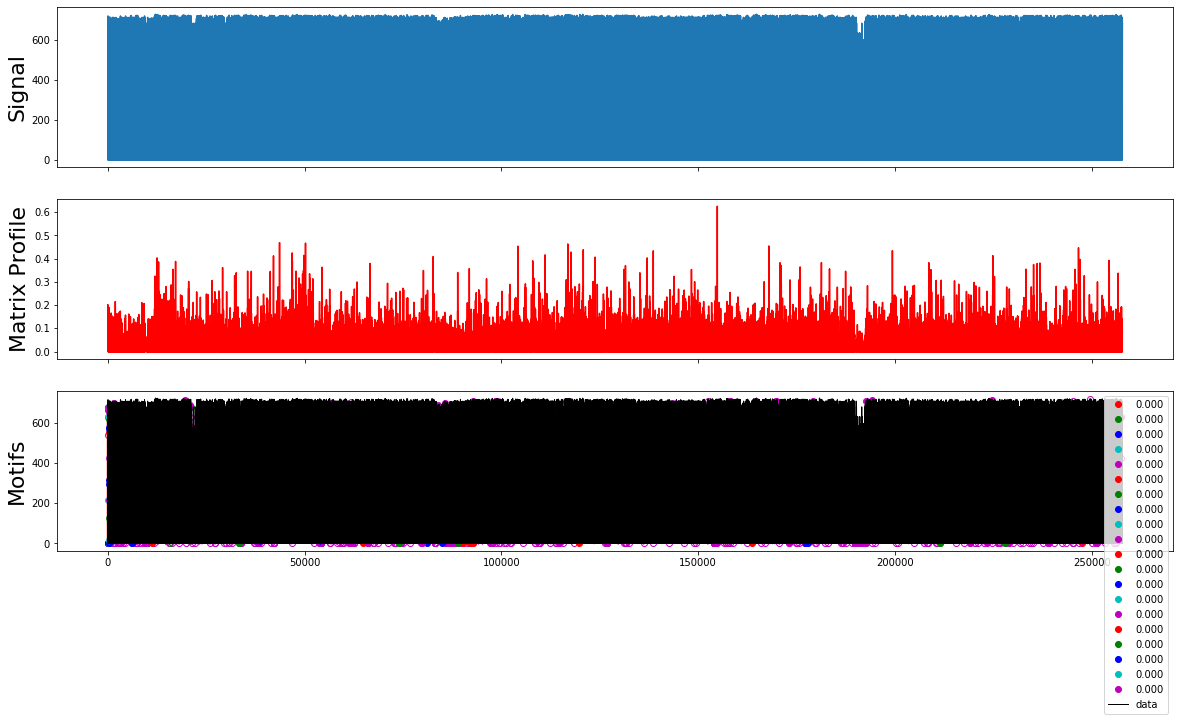

['break1', 'l1', 'c1', 'l1', 'c8']
['break1', 'l1', 'c1', 'l1', 'c8']
['break1', 'l1', 'c1', 'l1', 'c8']

['v1', 'l1', 'c9', 'l1', 'c14']
['v1', 'l1', 'c9', 'l1', 'c14']

['c1', 'v1', 'e1', 'v1', 'e2']
['c1', 'v1', 'e1', 'v1', 'e2']
['c1', 'v1', 'e1', 'v1', 'e2']

['l1', 'c3', 'v1', 'c4', 'l1']
['l1', 'c3', 'v1', 'c4', 'l1']

['s2', 'c1', 'v1', 'c4', 'break1']
['s2', 'c1', 'v1', 'c4', 'break1']

['v1', 'c1', 's2', 'c12', 'v1']
['v1', 'c1', 's2', 'c12', 'v1']

['v1', 'c9', 'break1', 'c11', 'break1']
['v1', 'c9', 'break1', 'c11', 'break1']

['break1', 'c1', 'v1', 'c4', 'v1']
['break1', 'c1', 'v1', 'c4', 'v1']
['break1', 'c1', 'v1', 'c4', 'v1']
['break1', 'c1', 'v1', 'c4', 'v1']
['break1', 'c1', 'v1', 'c4', 'v1']
['break1', 'c1', 'v1', 'c4', 'v1']
['break1', 'c1', 'v1', 'c4', 'v1']
['break1', 'c1', 'v1', 'c4', 'v1']

['e1', 'c1', 's2', 'e1', 's2']
['e1', 'c1', 's2', 'e1', 's2']

['v1', 'c1', 'v1', 'c1', 'v1']
['e1', 'c1', 'e1', 'c1', 'e1']
['l1', 'c1', 'l1', 'c1', 'l1']
['l1', 'c2', 'l1',

In [15]:
get_exact_patterns(sax_all)

In [44]:
def get_activities(df, size = 5):
    df['category2'][df['category2']=='communal'] = 'z'
    df['category'] = df['category2'].apply(lambda x: x[0])
    users1 = []
    actions1 = []
    users = np.array(df.userID.tolist())
    sessions = np.array(df.session.tolist())
    for i in range(1,len(users)):
        if users[i] != users[i-1]:
            actions1.append('stop')
            users1.append(users1[-1])
        elif sessions[i] != sessions[i-1]:
            actions1.append('break')
            users1.append(users1[-1])
        actions1.append(df.category[i])
        users1.append(users[i])
    actions_new = pd.DataFrame({'userID':users1, 'actions':actions1})
    
    
    my_list = []
    for name, groups in actions_new.groupby('userID'):
        user_list = [['0',1]]
        cnt_list = 0
        category = groups.actions.tolist()
        for i in range(0,len(category)):
            if category[i] == user_list[cnt_list][0]:
                user_list[cnt_list][1]+=1
            else:
                user_list.append([category[i],1])
                cnt_list+=1
        my_list.append(user_list[1:])
    new_list = my_list[:]    
    for i in range(0,len(my_list)):
        my_list[i] = ["".join([str(k) for k in j]) for j in my_list[i]]
    return my_list, actions_new, new_list

In [45]:
activities = get_activities(all1)

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
activities[1]

userID actions
0            10       l
1            10   break
2            10       s
3            10       e
4            10       e
...         ...     ...
2749458  999716       c
2749459  999716       c
2749460  999716       c
2749461  999716       c
2749462  999716       c

[2749463 rows x 2 columns]

In [46]:
activities[0]

[['e1', 'stop1'],
 ['l1', 'break1', 's1', 'e2', 'stop1'],
 ['c39', 'break1', 'v1', 'stop1'],
 ['c59', 'stop1'],
 ['c200', 'v1', 's1', 'e2', 'v5', 'e5', 'c1', 'stop1'],
 ['c42',
  'break1',
  'c9',
  'e5',
  'c177',
  's2',
  'e2',
  'c34',
  'z1',
  'break1',
  'l1',
  'c1',
  'l1',
  'c8',
  'l1',
  'c37',
  'break1',
  'l2',
  'c448',
  'e3',
  'c113',
  'p1',
  'z2',
  'p3',
  'stop1'],
 ['v2',
  'z2',
  'v2',
  'c5',
  'v1',
  'c44',
  'v1',
  'break1',
  'c4',
  'v1',
  'l1',
  'c9',
  'l1',
  'c14',
  'break1',
  'v1',
  'break1',
  'c58',
  'break1',
  'e2',
  'c18',
  'v1',
  'c7',
  'break1',
  'e1',
  's1',
  'c3',
  'l1',
  'c9',
  'l2',
  'c56',
  's1',
  'c30',
  'l1',
  'c39',
  'e1',
  'c1',
  's3',
  'c8',
  'v1',
  'c43',
  'break1',
  'c20',
  'v1',
  'c5',
  's2',
  'c38',
  'v1',
  'l1',
  'c7',
  'e1',
  'v2',
  'l1',
  'v4',
  'c1',
  'l1',
  'c64',
  'v2',
  'break1',
  'c73',
  'e1',
  'c1',
  'v1',
  'e1',
  'v1',
  'e2',
  'c1',
  'break1',
  'c12',
  'break1'

In [20]:
all1.category2.value_counts()

classify            2523660
view discussions      65237
exploring             45947
learning              34486
socialize             17205
z                      8131
personal               4146
Name: category2, dtype: int64

In [21]:
c_tot = 2523660

classify            414092
learning              9631
view discussions      6669
exploring             4717
z                     1394
socialize              614
personal               596
Name: category2, dtype: int64

In [24]:
workflow = {1: 1610, 2:1934, 3:1935, 4:2360, 5:2117}

In [25]:
all1.category2[all_data.links_workflow == workflow[1]].value_counts()

classify            414092
learning              9631
view discussions      6669
exploring             4717
z                     1394
socialize              614
personal               596
Name: category2, dtype: int64

In [26]:
all1.category2[all_data.links_workflow == workflow[2]].value_counts()

classify            391043
learning              5283
view discussions      4386
exploring             3162
socialize              846
z                      661
personal               369
Name: category2, dtype: int64

In [27]:
all1.category2[all_data.links_workflow == workflow[3]].value_counts()

classify            625443
view discussions      7860
exploring             7628
learning              5823
socialize             1751
z                     1126
personal               595
Name: category2, dtype: int64

In [28]:
all1.category2[all_data.links_workflow == workflow[4]].value_counts()

classify            900282
view discussions     25076
exploring            17146
learning              7634
socialize             5649
z                     3055
personal              1402
Name: category2, dtype: int64

In [29]:
all1.category2[all_data.links_workflow == workflow[5]].value_counts()

classify            192800
view discussions     19314
exploring            11070
socialize             8034
z                     1583
personal              1059
learning               617
Name: category2, dtype: int64

In [30]:
classify_cnts = [414092, 391043, 625443, 900282, 192800]

In [36]:
mean1 = np.mean(classify_cnts)

In [37]:
stdev1 = np.std(classify_cnts, ddof = 1)

In [47]:
activities[0]

[['e1', 'stop1'],
 ['l1', 'break1', 's1', 'e2', 'stop1'],
 ['c39', 'break1', 'v1', 'stop1'],
 ['c59', 'stop1'],
 ['c200', 'v1', 's1', 'e2', 'v5', 'e5', 'c1', 'stop1'],
 ['c42',
  'break1',
  'c9',
  'e5',
  'c177',
  's2',
  'e2',
  'c34',
  'z1',
  'break1',
  'l1',
  'c1',
  'l1',
  'c8',
  'l1',
  'c37',
  'break1',
  'l2',
  'c448',
  'e3',
  'c113',
  'p1',
  'z2',
  'p3',
  'stop1'],
 ['v2',
  'z2',
  'v2',
  'c5',
  'v1',
  'c44',
  'v1',
  'break1',
  'c4',
  'v1',
  'l1',
  'c9',
  'l1',
  'c14',
  'break1',
  'v1',
  'break1',
  'c58',
  'break1',
  'e2',
  'c18',
  'v1',
  'c7',
  'break1',
  'e1',
  's1',
  'c3',
  'l1',
  'c9',
  'l2',
  'c56',
  's1',
  'c30',
  'l1',
  'c39',
  'e1',
  'c1',
  's3',
  'c8',
  'v1',
  'c43',
  'break1',
  'c20',
  'v1',
  'c5',
  's2',
  'c38',
  'v1',
  'l1',
  'c7',
  'e1',
  'v2',
  'l1',
  'v4',
  'c1',
  'l1',
  'c64',
  'v2',
  'break1',
  'c73',
  'e1',
  'c1',
  'v1',
  'e1',
  'v1',
  'e2',
  'c1',
  'break1',
  'c12',
  'break1'

In [48]:
activities[2]

[[['e', 1], ['stop', 1]],
 [['l', 1], ['break', 1], ['s', 1], ['e', 2], ['stop', 1]],
 [['c', 39], ['break', 1], ['v', 1], ['stop', 1]],
 [['c', 59], ['stop', 1]],
 [['c', 200],
  ['v', 1],
  ['s', 1],
  ['e', 2],
  ['v', 5],
  ['e', 5],
  ['c', 1],
  ['stop', 1]],
 [['c', 42],
  ['break', 1],
  ['c', 9],
  ['e', 5],
  ['c', 177],
  ['s', 2],
  ['e', 2],
  ['c', 34],
  ['z', 1],
  ['break', 1],
  ['l', 1],
  ['c', 1],
  ['l', 1],
  ['c', 8],
  ['l', 1],
  ['c', 37],
  ['break', 1],
  ['l', 2],
  ['c', 448],
  ['e', 3],
  ['c', 113],
  ['p', 1],
  ['z', 2],
  ['p', 3],
  ['stop', 1]],
 [['v', 2],
  ['z', 2],
  ['v', 2],
  ['c', 5],
  ['v', 1],
  ['c', 44],
  ['v', 1],
  ['break', 1],
  ['c', 4],
  ['v', 1],
  ['l', 1],
  ['c', 9],
  ['l', 1],
  ['c', 14],
  ['break', 1],
  ['v', 1],
  ['break', 1],
  ['c', 58],
  ['break', 1],
  ['e', 2],
  ['c', 18],
  ['v', 1],
  ['c', 7],
  ['break', 1],
  ['e', 1],
  ['s', 1],
  ['c', 3],
  ['l', 1],
  ['c', 9],
  ['l', 2],
  ['c', 56],
  ['s', 1],


In [49]:
flat_list1 = [item for sublist in activities[0] for item in sublist]

In [50]:
flat_list1

['e1',
 'stop1',
 'l1',
 'break1',
 's1',
 'e2',
 'stop1',
 'c39',
 'break1',
 'v1',
 'stop1',
 'c59',
 'stop1',
 'c200',
 'v1',
 's1',
 'e2',
 'v5',
 'e5',
 'c1',
 'stop1',
 'c42',
 'break1',
 'c9',
 'e5',
 'c177',
 's2',
 'e2',
 'c34',
 'z1',
 'break1',
 'l1',
 'c1',
 'l1',
 'c8',
 'l1',
 'c37',
 'break1',
 'l2',
 'c448',
 'e3',
 'c113',
 'p1',
 'z2',
 'p3',
 'stop1',
 'v2',
 'z2',
 'v2',
 'c5',
 'v1',
 'c44',
 'v1',
 'break1',
 'c4',
 'v1',
 'l1',
 'c9',
 'l1',
 'c14',
 'break1',
 'v1',
 'break1',
 'c58',
 'break1',
 'e2',
 'c18',
 'v1',
 'c7',
 'break1',
 'e1',
 's1',
 'c3',
 'l1',
 'c9',
 'l2',
 'c56',
 's1',
 'c30',
 'l1',
 'c39',
 'e1',
 'c1',
 's3',
 'c8',
 'v1',
 'c43',
 'break1',
 'c20',
 'v1',
 'c5',
 's2',
 'c38',
 'v1',
 'l1',
 'c7',
 'e1',
 'v2',
 'l1',
 'v4',
 'c1',
 'l1',
 'c64',
 'v2',
 'break1',
 'c73',
 'e1',
 'c1',
 'v1',
 'e1',
 'v1',
 'e2',
 'c1',
 'break1',
 'c12',
 'break1',
 'c24',
 'e1',
 'break1',
 'c14',
 'v1',
 'c67',
 'l1',
 'c3',
 'v1',
 'c4',
 'l1',
 'c2

In [51]:
import re

In [62]:
max1 = 0
for i in flat_list1:
    if re.match('c',i):
        if int(re.findall('\d+', i)[0]) > max1:
            max1 = int(re.findall('\d+', i)[0])

In [63]:
max1

2119

In [99]:
def get_activities_cnts(df):
    df['category2'][df['category2']=='communal'] = 'z'
    df['category'] = df['category2'].apply(lambda x: x[0])
    users1 = []
    actions1 = []
    users = np.array(df.userID.tolist())
    sessions = np.array(df.session.tolist())
    for i in range(1,len(users)):
        if users[i] != users[i-1]:
            actions1.append('stop')
            users1.append(users1[-1])
        elif sessions[i] != sessions[i-1]:
            actions1.append('break')
            users1.append(users1[-1])
        actions1.append(df.category[i])
        users1.append(users[i])
    actions_new = pd.DataFrame({'userID':users1, 'actions':actions1})
    
    
    my_list = []
    for name, groups in actions_new.groupby('userID'):
        user_list = [['0',1]]
        cnt_list = 0
        category = groups.actions.tolist()
        for i in range(0,len(category)):
            if category[i] == user_list[cnt_list][0]:
                user_list[cnt_list][1]+=1
            else:
                user_list.append([category[i],1])
                cnt_list+=1
        my_list.append(user_list[1:])    
    
    for i in range(0,len(my_list)):
        my_list[i] = ["".join([str(k) for k in j]) for j in my_list[i]]
    
    flat_list1 = [item for sublist in my_list for item in sublist]
    print(flat_list1[:10])
    new_cnt = []
    print("Starting counts...")
    for i in flat_list1:
        if re.match('c',i):
            new_cnt.append(int(re.findall('\d+', i)[0]))
    
    print(new_cnt[:10])
    return my_list,new_cnt

In [106]:
act_c = get_activities_cnts(all1)

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


['e1', 'stop1', 'l1', 'break1', 's1', 'e2', 'stop1', 'c39', 'break1', 'v1']
Starting counts...
[39, 59, 200, 1, 42, 9, 177, 34, 1, 8]


In [107]:
act_c[1]

[39,
 59,
 200,
 1,
 42,
 9,
 177,
 34,
 1,
 8,
 37,
 448,
 113,
 5,
 44,
 4,
 9,
 14,
 58,
 18,
 7,
 3,
 9,
 56,
 30,
 39,
 1,
 8,
 43,
 20,
 5,
 38,
 7,
 1,
 64,
 73,
 1,
 1,
 12,
 24,
 14,
 67,
 3,
 4,
 28,
 34,
 51,
 17,
 1,
 4,
 8,
 2,
 1,
 4,
 18,
 2,
 13,
 6,
 15,
 3,
 6,
 10,
 5,
 6,
 1,
 6,
 3,
 27,
 4,
 62,
 6,
 1,
 13,
 4,
 41,
 1,
 12,
 9,
 11,
 1,
 4,
 35,
 1,
 12,
 69,
 37,
 11,
 34,
 59,
 1,
 1,
 5,
 2,
 1,
 15,
 3,
 8,
 37,
 27,
 42,
 3,
 54,
 1,
 1,
 1,
 49,
 25,
 17,
 3,
 42,
 5,
 3,
 6,
 2,
 4,
 7,
 21,
 3,
 12,
 18,
 1,
 8,
 2,
 20,
 19,
 10,
 21,
 4,
 7,
 6,
 37,
 14,
 11,
 8,
 28,
 22,
 1,
 8,
 8,
 1,
 1,
 1,
 1,
 10,
 93,
 19,
 11,
 92,
 19,
 5,
 3,
 5,
 18,
 8,
 11,
 7,
 13,
 6,
 3,
 1,
 60,
 38,
 4,
 28,
 7,
 12,
 127,
 35,
 19,
 1,
 74,
 21,
 6,
 9,
 1,
 119,
 10,
 2,
 1,
 6,
 3,
 53,
 14,
 10,
 10,
 18,
 1,
 1,
 33,
 46,
 17,
 19,
 114,
 212,
 56,
 6,
 34,
 61,
 23,
 51,
 40,
 6,
 16,
 15,
 13,
 29,
 105,
 9,
 3,
 28,
 104,
 94,
 1,
 2,
 65,
 37,
 15,
 4,
 1,

In [108]:
mean_all = np.mean(act_c[1])

In [109]:
std_all = np.std(act_c[1])

In [112]:
act_c1 = get_activities_cnts(all1[all_data.links_workflow == workflow[1]].reset_index())

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


['e1', 'stop1', 'l1', 'break1', 's1', 'e2', 'stop1', 'c39', 'break1', 'v1']
Starting counts...
[39, 59, 19, 42, 1, 5, 44, 29, 9, 1]


In [113]:
act_c1[1]

[39,
 59,
 19,
 42,
 1,
 5,
 44,
 29,
 9,
 1,
 119,
 10,
 2,
 1,
 6,
 17,
 19,
 114,
 212,
 56,
 6,
 34,
 61,
 10,
 15,
 13,
 29,
 3,
 28,
 19,
 30,
 1,
 4,
 1,
 32,
 1,
 6,
 116,
 20,
 4,
 3,
 27,
 15,
 287,
 20,
 69,
 20,
 1,
 1,
 1,
 3,
 82,
 522,
 537,
 50,
 1,
 336,
 63,
 51,
 184,
 71,
 21,
 274,
 198,
 40,
 80,
 5,
 70,
 4,
 11,
 20,
 3,
 2,
 19,
 2,
 7,
 1,
 4,
 2,
 9,
 9,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 1,
 12,
 2,
 1,
 2,
 6,
 1,
 3,
 3,
 6,
 2,
 1,
 2,
 2,
 3,
 4,
 1,
 3,
 4,
 109,
 22,
 25,
 1,
 22,
 21,
 73,
 49,
 119,
 219,
 1,
 143,
 27,
 335,
 19,
 28,
 24,
 15,
 6,
 1,
 4,
 105,
 25,
 10,
 1,
 2,
 5,
 15,
 5,
 51,
 11,
 14,
 2,
 5,
 15,
 3,
 73,
 1,
 2,
 1,
 1,
 3,
 6,
 3,
 16,
 4,
 11,
 1,
 4,
 31,
 9,
 24,
 19,
 70,
 61,
 28,
 14,
 71,
 4,
 3,
 7,
 4,
 19,
 51,
 27,
 34,
 4,
 13,
 9,
 89,
 160,
 4,
 9,
 19,
 108,
 6,
 5,
 2,
 16,
 8,
 15,
 5,
 1,
 14,
 5,
 21,
 14,
 19,
 3,
 6,
 15,
 6,
 9,
 7,
 22,
 19,
 7,
 2,
 17,
 9,
 10,
 24,
 19,
 27,
 5,
 1,
 

In [119]:
mean_1 = np.mean(act_c1[1])

In [120]:
std_1 = np.std(act_c1[1])

In [114]:
act_c2 = get_activities_cnts(all1[all_data.links_workflow == workflow[2]].reset_index())

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


['c70', 'stop1', 'c8', 'e5', 'c177', 's2', 'e2', 'c34', 'z1', 'break1']
Starting counts...
[70, 8, 177, 34, 1, 8, 4, 9, 14, 58]


In [115]:
act_c2[1]

[70,
 8,
 177,
 34,
 1,
 8,
 4,
 9,
 14,
 58,
 18,
 7,
 3,
 9,
 56,
 30,
 39,
 1,
 8,
 43,
 20,
 5,
 38,
 7,
 1,
 64,
 73,
 1,
 1,
 98,
 35,
 19,
 1,
 74,
 21,
 3,
 53,
 14,
 23,
 51,
 61,
 104,
 94,
 1,
 2,
 65,
 3,
 1,
 3,
 2,
 39,
 30,
 7,
 6,
 6,
 45,
 13,
 13,
 171,
 25,
 57,
 256,
 50,
 1,
 8,
 2,
 55,
 15,
 12,
 18,
 14,
 24,
 6,
 5,
 5,
 5,
 5,
 4,
 2,
 8,
 8,
 42,
 7,
 9,
 80,
 122,
 52,
 49,
 53,
 27,
 29,
 23,
 29,
 63,
 13,
 37,
 10,
 3,
 42,
 3,
 39,
 3,
 10,
 1,
 6,
 16,
 10,
 36,
 1,
 19,
 31,
 171,
 4,
 46,
 32,
 17,
 2,
 6,
 6,
 2,
 1,
 24,
 24,
 2,
 11,
 6,
 14,
 1,
 12,
 23,
 11,
 21,
 2,
 11,
 11,
 5,
 9,
 20,
 6,
 19,
 135,
 27,
 4,
 11,
 27,
 55,
 8,
 13,
 49,
 69,
 128,
 19,
 31,
 33,
 20,
 4,
 6,
 38,
 18,
 10,
 62,
 74,
 67,
 5,
 9,
 6,
 44,
 14,
 8,
 1,
 6,
 22,
 122,
 23,
 23,
 15,
 1,
 1,
 3,
 1,
 1,
 2,
 1,
 5,
 1,
 4,
 1,
 2,
 1,
 6,
 1,
 1,
 1,
 1,
 1,
 1,
 4,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 3,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 1,


In [121]:
mean_2 = np.mean(act_c2[1])

In [122]:
std_2 = np.std(act_c2[1])

In [123]:
act_c3 = get_activities_cnts(all1[all_data.links_workflow == workflow[3]].reset_index())

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


['c111', 'v1', 's1', 'e2', 'v5', 'e5', 'c1', 'stop1', 'c37', 'break1']
Starting counts...
[111, 1, 37, 448, 113, 12, 24, 14, 67, 6]


In [124]:
mean_3 = np.mean(act_c3[1])

In [125]:
std_3 = np.std(act_c3[1])

In [126]:
act_c4 = get_activities_cnts(all1[all_data.links_workflow == workflow[4]].reset_index())

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


['c3', 'v1', 'c4', 'l1', 'c28', 'v1', 'c34', 'break1', 'c51', 'e1']
Starting counts...
[3, 4, 28, 34, 51, 17, 1, 4, 8, 2]


In [127]:
mean_4 = np.mean(act_c4[1])

In [128]:
std_4 = np.std(act_c4[1])

In [129]:
act_c5 = get_activities_cnts(all1[all_data.links_workflow == workflow[5]].reset_index())

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


['c25', 'v1', 'c4', 'p3', 'v1', 'c2', 'break1', 'c1', 's2', 'c28']
Starting counts...
[25, 4, 2, 1, 28, 9, 1, 4, 3, 2]


In [130]:
mean_5 = np.mean(act_c5[1])

In [139]:
std_5 = np.std(act_c5[1])

In [133]:
m = [mean_1, mean_2,mean_3,mean_4,mean_5]

In [134]:
m

[21.3570581257414,
 28.30765889677139,
 34.410321302816904,
 24.91644525628252,
 15.058892447082714]

In [135]:
s = [std_1, std_2, std_3, std_4, std_5]

In [136]:
s

[38.90714727345678,
 52.36381016647355,
 63.6622609008898,
 49.589755260060564,
 30.62595884599624]

In [142]:
gc.collect()

20

### Workflow 1 classifiy count distribution

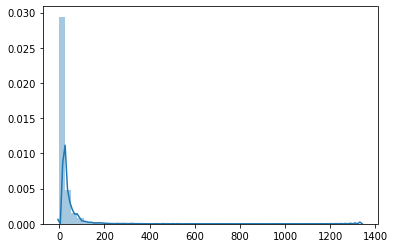

In [146]:
sns.distplot(act_c1[1])

### Workflow 2 classifiy count distribution

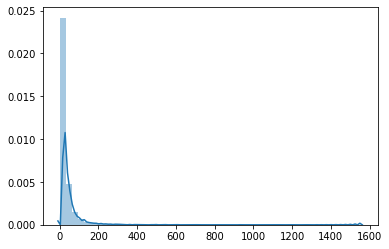

In [147]:
sns.distplot(act_c2[1])

### Workflow 3 classifiy count distribution

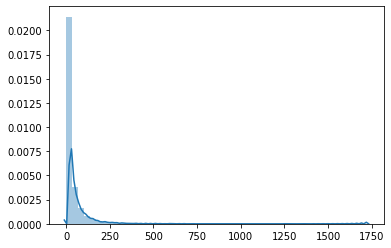

In [148]:
sns.distplot(act_c3[1])

### Workflow 4 classifiy count distribution

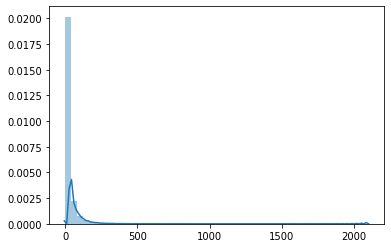

In [149]:
sns.distplot(act_c4[1])

### Workflow 5 classifiy count distribution

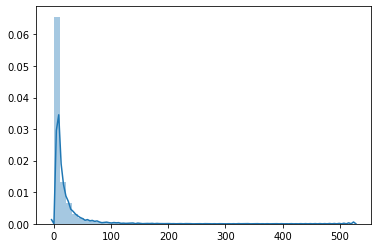

In [150]:
sns.distplot(act_c5[1])

In [151]:
def bins(data):
    Q1 = np.percentile(data, 25, interpolation = 'midpoint')
    Q3 = np.percentile(data, 75, interpolation = 'midpoint')
    lower_fence = Q1 - 1.5*(Q3-Q1)
    upper_fence = Q3 + 1.5*(Q3-Q1)
    return lower_fence,upper_fence

In [152]:
bins(act_c1[1])

(-26.0, 54.0)

In [153]:
bins(act_c2[1])

(-39.5, 76.5)

In [154]:
bins(act_c3[1])

(-45.5, 86.5)

In [155]:
bins(act_c4[1])

(-31.5, 60.5)

In [156]:
bins(act_c5[1])

(-17.5, 34.5)

[4.0, 10.0, 24.0]

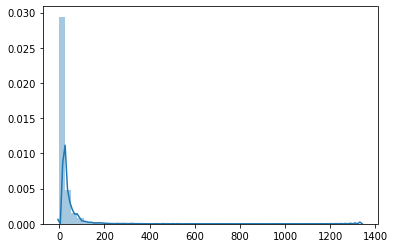

In [161]:
sns.distplot(act_c1[1])

quantile_list = [25, 50, 75]
quantiles = [np.percentile(act_c1[1], i, interpolation = 'midpoint') for i in quantile_list]
quantiles

In [168]:
def bins_qnt(data):
    quantile_list = [25, 50, 75]
    quantiles = [np.percentile(data, i, interpolation = 'midpoint') for i in quantile_list]
    quantiles
    return quantiles

In [169]:
bins1 = bins_qnt(act_c1[1])
bins1

[4.0, 10.0, 24.0]

In [170]:
bins2 = bins_qnt(act_c2[1])
bins2

[4.0, 13.0, 33.0]

In [171]:
bins3 = bins_qnt(act_c3[1])
bins3

[4.0, 13.0, 37.0]

In [172]:
bins4 = bins_qnt(act_c4[1])
bins4

[3.0, 10.0, 26.0]

In [173]:
bins5 = bins_qnt(act_c5[1])
bins5

[2.0, 6.0, 15.0]

In [208]:
bins1

[4.0, 10.0, 24.0]

In [224]:
def get_patterns_bins(df, abin, size = 5):
    df['category2'][df['category2']=='communal'] = 'z'
    df['category'] = df['category2'].apply(lambda x: x[0])
    users1 = []
    actions1 = []
    users = np.array(df.userID.tolist())
    sessions = np.array(df.session.tolist())
    for i in range(1,len(users)):
        if users[i] != users[i-1]:
            actions1.append('stop')
            users1.append(users1[-1])
        elif sessions[i] != sessions[i-1]:
            actions1.append('break')
            users1.append(users1[-1])
        actions1.append(df.category[i])
        users1.append(users[i])
    actions_new = pd.DataFrame({'userID':users1, 'actions':actions1})
    
    
    my_list = []
    for name, groups in actions_new.groupby('userID'):
        user_list = [['0',1]]
        cnt_list = 0
        category = groups.actions.tolist()
        for i in range(0,len(category)):
            if category[i] == user_list[cnt_list][0]:
                user_list[cnt_list][1]+=1
            else:                    
                '''
                if user_list[cnt_list][0] == 'c':
                    if user_list[cnt_list][1] >= abin[2]:
                        user_list[cnt_list][1] = '-chigh'
                    elif user_list[cnt_list][1] >= abin[0]:
                        user_list[cnt_list][1] = '-bmed'
                    else:
                        user_list[cnt_list][1] = '-alow'
                '''
                user_list.append([category[i],1])
                cnt_list+=1
       
        my_list.append(user_list[1:])
        
    for i in range(0,len(my_list)):
        my_list[i] = ["".join([str(k) for k in j]) for j in my_list[i]]
    
    print("My list:")
    print(my_list[:10])
    #users = []
    #for names,groups in df.groupby('userID'):
    #    users.append(names)
    print("Start encoding....")
    for i in range(0, len(my_list)):
        for j in range(0, len(my_list[i])):
            if re.match('c',my_list[i][j]):
                if int(re.findall('\d+',my_list[i][j])[0]) >= abin[2]:
                    my_list[i][j] = re.sub('\d+','-chigh', my_list[i][j])
                elif int(re.findall('\d+',my_list[i][j])[0]) >= abin[0]:
                    my_list[i][j] = re.sub('\d+','-bmed', my_list[i][j])
                else:
                    my_list[i][j] = re.sub('\d+','-alow', my_list[i][j])

    
    actions = []
    for i in my_list:
        actions.append(",".join(i))
    
    #df_temp = pd.DataFrame({'userID':users, 'actions':actions})
    flat_list_df = [item for sublist in actions for item in sublist.split(",")]
    print("Sample activities...")
    print(flat_list_df[:20])
                
    
    lbl = LabelEncoder() 
    lbl.fit(flat_list_df)
    actions_lbl = [lbl.transform(i.split(",")) for i in actions]
    flat_lbls_df = [item for sublist in actions_lbl for item in sublist]
    sax_df = sax_via_window(flat_lbls_df,size,size,size,"none", 0.01)
    return [sax_df,flat_list_df]

In [205]:
re.sub('\d+', 'high', 'c15') 

'chigh'

In [176]:
super_1 = pd.read_csv('./superusers_lvl1_2.csv')
other_1 = pd.read_csv('./other_lvl1_2.csv')
s1 = super_1[['userID','session','category2']]
o1 = other_1[['userID','session','category2']]

In [225]:
sax_s1 = get_patterns_bins(s1, bins1)

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


My list:
[['c15'], ['c2', 'stop1'], ['c380', 'break1', 'c332', 'v1', 'z1', 'v1', 'l1', 'stop1'], ['c9', 'stop1'], ['c2', 'l2', 'c1', 'l5', 'v3', 'l1', 'v4', 'l1', 'c13', 'stop1'], ['c10', 'e1', 'v2', 'break1', 's9', 'c6', 's4', 'c11', 's2', 'c7', 'p1', 'c6', 's1', 'break1', 's1', 'break1', 'v1', 'e1', 'stop1'], ['c1', 'v2', 'c13', 'stop1'], ['c13', 'l1', 'c1', 'l2', 'break1', 'c7', 'l1', 'c2', 'l1', 'stop1'], ['c41', 'l1', 'c26', 'l1', 'c15', 'l1', 'c1', 'l1', 'c39', 'l1', 'e1', 'l1', 'c11', 'v1', 'c27', 'l1', 'c100', 'l1', 'c32', 'l1', 's2', 'c15', 'l1', 'c91', 'v1', 'c4', 'v1', 'c19', 'v1', 'c17', 'break1', 'c23', 'v1', 'c12', 'e1', 'c1', 'e1', 'c9', 'e1', 'c2', 'e2', 'c22', 'v1', 'c31', 'l1', 'c4', 'l1', 'stop1'], ['c4', 'v2', 'c41', 'break1', 'c1', 'break1', 'c37', 'v1', 'break1', 'c10', 'stop1']]
Start encoding....
Sample activities...
['c-bmed', 'c-alow', 'stop1', 'c-chigh', 'break1', 'c-chigh', 'v1', 'z1', 'v1', 'l1', 'stop1', 'c-bmed', 'stop1', 'c-alow', 'l2', 'c-alow', 'l5', '

In [226]:
sax_s1[1]

['c-bmed',
 'c-alow',
 'stop1',
 'c-chigh',
 'break1',
 'c-chigh',
 'v1',
 'z1',
 'v1',
 'l1',
 'stop1',
 'c-bmed',
 'stop1',
 'c-alow',
 'l2',
 'c-alow',
 'l5',
 'v3',
 'l1',
 'v4',
 'l1',
 'c-bmed',
 'stop1',
 'c-bmed',
 'e1',
 'v2',
 'break1',
 's9',
 'c-bmed',
 's4',
 'c-bmed',
 's2',
 'c-bmed',
 'p1',
 'c-bmed',
 's1',
 'break1',
 's1',
 'break1',
 'v1',
 'e1',
 'stop1',
 'c-alow',
 'v2',
 'c-bmed',
 'stop1',
 'c-bmed',
 'l1',
 'c-alow',
 'l2',
 'break1',
 'c-bmed',
 'l1',
 'c-alow',
 'l1',
 'stop1',
 'c-chigh',
 'l1',
 'c-chigh',
 'l1',
 'c-bmed',
 'l1',
 'c-alow',
 'l1',
 'c-chigh',
 'l1',
 'e1',
 'l1',
 'c-bmed',
 'v1',
 'c-chigh',
 'l1',
 'c-chigh',
 'l1',
 'c-chigh',
 'l1',
 's2',
 'c-bmed',
 'l1',
 'c-chigh',
 'v1',
 'c-bmed',
 'v1',
 'c-bmed',
 'v1',
 'c-bmed',
 'break1',
 'c-bmed',
 'v1',
 'c-bmed',
 'e1',
 'c-alow',
 'e1',
 'c-bmed',
 'e1',
 'c-alow',
 'e2',
 'c-bmed',
 'v1',
 'c-chigh',
 'l1',
 'c-bmed',
 'l1',
 'stop1',
 'c-bmed',
 'v2',
 'c-chigh',
 'break1',
 'c-alow'

In [231]:
most_common(sax_s1, 20)

Total Number of patterns: 1
dadad, number of occurances:  29
['l1', 'c-chigh', 'l1', 'c-bmed', 'l1']
['v1', 'c-bmed', 'v1', 'c-bmed', 'v1']
['stop1', 'c-bmed', 'stop1', 'c-bmed', 'stop1']
['l1', 'c-bmed', 'l1', 'c-alow', 'l1']
['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']
['stop1', 'c-bmed', 'stop1', 'c-chigh', 'stop1']



In [232]:
sax_o1 = get_patterns_bins(o1, bins1)

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mistr\Anaconda3\lib\site-packages\pandas\core\generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This

My list:
[['e1', 'stop1'], ['l1', 'break1', 's1', 'e2', 'stop1'], ['c39', 'break1', 'v1', 'stop1'], ['c59', 'stop1'], ['c19', 'stop1'], ['c42', 'break1', 'c1', 'stop1'], ['c5', 'v1', 'c44', 'v1', 'stop1'], ['c29', 'stop1'], ['c9', 'break1', 'c1', 'stop1'], ['c119', 'p1', 'stop1']]
Start encoding....
Sample activities...
['e1', 'stop1', 'l1', 'break1', 's1', 'e2', 'stop1', 'c-chigh', 'break1', 'v1', 'stop1', 'c-chigh', 'stop1', 'c-bmed', 'stop1', 'c-chigh', 'break1', 'c-alow', 'stop1', 'c-bmed']


In [233]:
most_common(sax_o1)

Total Number of patterns: 72
aebea, number of occurances:  314
['break1', 's1', 'e2', 'stop1', 'c-chigh']
['break1', 'v1', 'e1', 'v1', 'break1']
['break1', 'v3', 'e3', 'v1', 'break1']
['e1', 'v8', 'e2', 'v3', 'e1']
['break1', 'v3', 'e1', 'v1', 'break1']
['e1', 'v4', 'e2', 'v4', 'break1']

aedad, number of occurances:  262
['break1', 'v1', 'stop1', 'c-chigh', 'stop1']
['break1', 'v1', 'stop1', 'c-bmed', 'stop1']
['c-alow', 'v1', 'l1', 'c-alow', 'l2']
['c-chigh', 'v1', 'stop1', 'c-chigh', 'stop1']
['c-chigh', 'z3', 'stop1', 'c-bmed', 'stop1']
['e1', 'v3', 's1', 'e1', 's1']

edada, number of occurances:  388
['v1', 'stop1', 'c-chigh', 'stop1', 'c-bmed']
['v1', 'stop1', 'c-bmed', 'stop1', 'c-chigh']
['v1', 'stop1', 'c-bmed', 'stop1', 'c-chigh']
['v1', 'stop1', 'c-chigh', 'stop1', 'c-bmed']
['v2', 's2', 'c-alow', 's2', 'c-alow']
['v3', 's4', 'c-bmed', 'v1', 'c-bmed']

dadad, number of occurances:  3400
['stop1', 'c-chigh', 'stop1', 'c-bmed', 'stop1']
['v1', 'break1', 'v1', 'break1', 'v1']
[

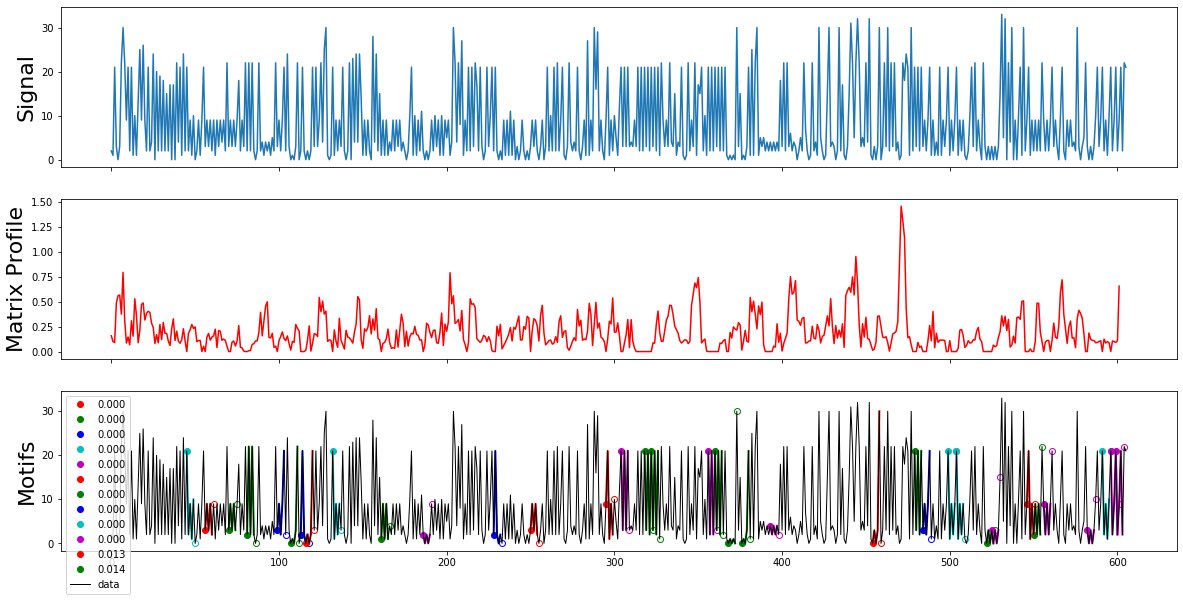

['c-chigh', 'l1', 'c-chigh', 'l1', 'c-bmed']
['c-chigh', 'l1', 'c-chigh', 'l1', 'c-bmed']

['c-chigh', 'l1', 'c-chigh', 'l1', 'c-chigh']
['c-bmed', 'v1', 'c-bmed', 'v1', 'c-bmed']
['c-alow', 'l1', 'c-alow', 'l1', 'c-alow']
['break1', 'c-alow', 'break1', 'c-alow', 'break1']
['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']
['c-bmed', 'l1', 'c-bmed', 'l1', 'c-bmed']

['c-bmed', 'stop1', 'c-bmed', 'break1', 'c-bmed']
['c-bmed', 'stop1', 'c-bmed', 'break1', 'c-bmed']

['stop1', 'c-alow', 'l1', 'c-bmed', 'l1']
['stop1', 'c-alow', 'l1', 'c-bmed', 'l1']
['stop1', 'c-alow', 'l1', 'c-bmed', 'l1']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']
['stop1', 'c-chigh', 'stop1', 'c-chigh', 'stop1']
['stop1', 'c-bmed', 'stop1', 'c-bmed', 'stop1']
['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']
['l1', 'c-bmed', 'l1', 'c-bmed', 'l1']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['l1', 'stop1', 'c-alow', 'l1', 'c-bmed']
['l1', 'stop1', 'c-alow

In [234]:
get_exact_patterns(sax_s1)

In [235]:
super_2 = pd.read_csv('./superusers_lvl2_2.csv')
other_2 = pd.read_csv('./other_lvl2_2.csv')
s2 = super_2[['userID','session','category2']]
o2 = other_2[['userID','session','category2']]

In [238]:
sax_s2 = get_patterns_bins(s1, bins2)

My list:
[['c15'], ['c2', 'stop1'], ['c380', 'break1', 'c332', 'v1', 'z1', 'v1', 'l1', 'stop1'], ['c9', 'stop1'], ['c2', 'l2', 'c1', 'l5', 'v3', 'l1', 'v4', 'l1', 'c13', 'stop1'], ['c10', 'e1', 'v2', 'break1', 's9', 'c6', 's4', 'c11', 's2', 'c7', 'p1', 'c6', 's1', 'break1', 's1', 'break1', 'v1', 'e1', 'stop1'], ['c1', 'v2', 'c13', 'stop1'], ['c13', 'l1', 'c1', 'l2', 'break1', 'c7', 'l1', 'c2', 'l1', 'stop1'], ['c41', 'l1', 'c26', 'l1', 'c15', 'l1', 'c1', 'l1', 'c39', 'l1', 'e1', 'l1', 'c11', 'v1', 'c27', 'l1', 'c100', 'l1', 'c32', 'l1', 's2', 'c15', 'l1', 'c91', 'v1', 'c4', 'v1', 'c19', 'v1', 'c17', 'break1', 'c23', 'v1', 'c12', 'e1', 'c1', 'e1', 'c9', 'e1', 'c2', 'e2', 'c22', 'v1', 'c31', 'l1', 'c4', 'l1', 'stop1'], ['c4', 'v2', 'c41', 'break1', 'c1', 'break1', 'c37', 'v1', 'break1', 'c10', 'stop1']]
Start encoding....
Sample activities...
['c-bmed', 'c-alow', 'stop1', 'c-chigh', 'break1', 'c-chigh', 'v1', 'z1', 'v1', 'l1', 'stop1', 'c-bmed', 'stop1', 'c-alow', 'l2', 'c-alow', 'l5', '

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [241]:
most_common(sax_s2, 20)

Total Number of patterns: 2
bebeb, number of occurances:  21
['c-bmed', 's4', 'c-bmed', 's2', 'c-bmed']
['c-bmed', 'l1', 'c-bmed', 'l1', 'c-bmed']
['c-bmed', 'stop1', 'c-bmed', 'stop1', 'c-bmed']
['c-bmed', 's2', 'c-bmed', 'p1', 'c-bmed']
['c-bmed', 'l1', 'c-bmed', 'l2', 'c-bmed']
['c-bmed', 'stop1', 'c-bmed', 'stop1', 'c-bmed']

dadad, number of occurances:  29
['l1', 'c-bmed', 'l1', 'c-bmed', 'l1']
['v1', 'c-bmed', 'v1', 'c-bmed', 'v1']
['stop1', 'c-bmed', 'stop1', 'c-bmed', 'stop1']
['l1', 'c-bmed', 'l1', 'c-alow', 'l1']
['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']
['stop1', 'c-bmed', 'stop1', 'c-bmed', 'stop1']



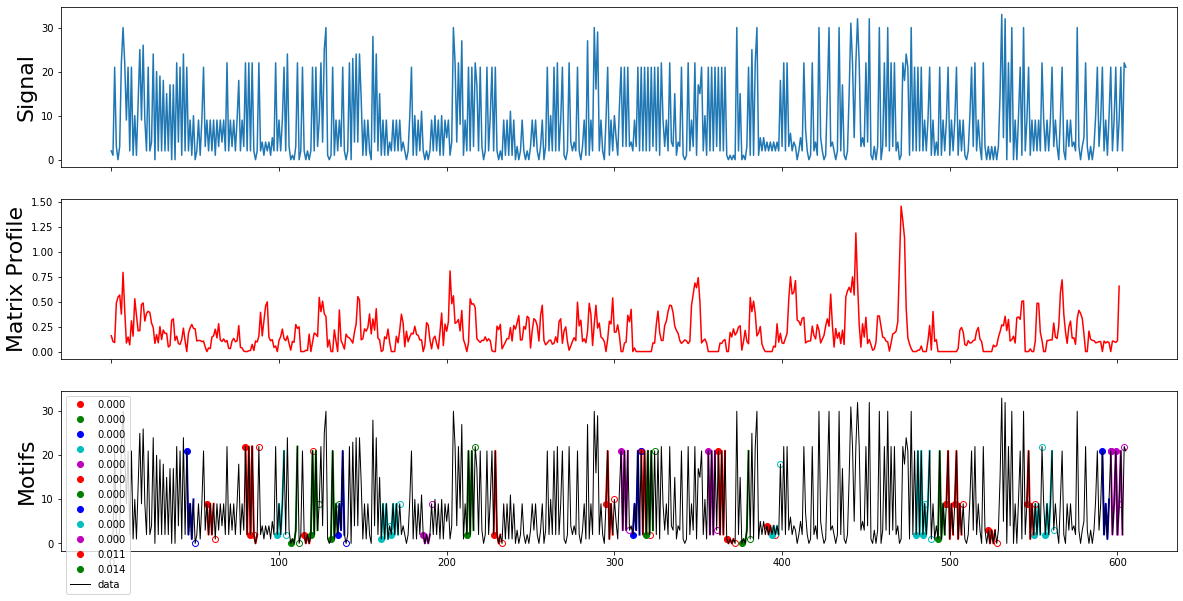

['l1', 'c-bmed', 'l1', 'c-bmed', 'l1']
['v1', 'c-bmed', 'v1', 'c-bmed', 'v1']
['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']
['stop1', 'c-bmed', 'stop1', 'c-bmed', 'stop1']
['stop1', 'c-bmed', 'stop1', 'c-bmed', 'stop1']
['c-alow', 'break1', 'c-alow', 'break1', 'c-alow']
['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-alow', 'stop1', 'c-alow', 'l1', 'c-bmed']
['c-alow', 'stop1', 'c-alow', 'l1', 'c-bmed']

['c-bmed', 'l1', 'c-chigh', 'stop1', 'c-bmed']
['c-bmed', 'l1', 'c-chigh', 'stop1', 'c-bmed']

['c-alow', 'l1', 'c-alow', 'l1', 'c-alow']
['c-bmed', 'l1', 'c-bmed', 'l1', 'c-bmed']
['c-bmed', 'e1', 'c-bmed', 'e1', 'c-bmed']
['c-bmed', 'stop1', 'c-bmed', 'stop1', 'c-bmed']
['c-bmed', 'l1', 'c-bmed', 'l1', 'c-bmed']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']
['stop1', 'c-chigh', 'stop1', 'c-chigh', 'stop1']
['stop1', 'c-bmed', 'stop1', 'c-bmed', 'stop1']

['l1', 'stop1', 'c-alow', 'l1', 'c-bmed']
['l1', 'stop1', 'c-alow', 'l

In [242]:
get_exact_patterns(sax_s2)

In [243]:
sax_o2 = get_patterns_bins(o2, bins2)

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mistr\Anaconda3\lib\site-packages\pandas\core\generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This

My list:
[['c70', 'stop1'], ['c8', 'e5', 'c177', 's2', 'e2', 'c34', 'z1', 'break1', 'l1', 'c1', 'l1', 'c8', 'l1', 'stop1'], ['c4', 'v1', 'l1', 'c9', 'l1', 'c14', 'break1', 'v1', 'break1', 'c58', 'break1', 'e2', 'c18', 'v1', 'c7', 'break1', 'e1', 's1', 'c3', 'l1', 'c9', 'l2', 'c56', 's1', 'c30', 'l1', 'c39', 'e1', 'c1', 's3', 'c8', 'v1', 'c43', 'break1', 'c20', 'v1', 'c5', 's2', 'c38', 'v1', 'l1', 'c7', 'e1', 'v2', 'l1', 'v4', 'c1', 'l1', 'c64', 'v2', 'break1', 'c73', 'e1', 'c1', 'v1', 'e1', 'v1', 'e2', 'c1', 'stop1'], ['c98', 'l1', 'c35', 'break1', 'c19', 'l1', 'c1', 'l1', 'c74', 'break1', 'l1', 'c21', 'v2', 'stop1'], ['c3', 'l1', 'c53', 'l1', 'c14', 'break1', 'l1', 'stop1'], ['c23', 'break1', 'c51', 'stop1'], ['c61', 'stop1'], ['c104', 'z1', 'break1', 'c94', 'v1', 'e1', 'break1', 'c1', 'break1', 'c2', 'v1', 'e1', 'break1', 'c65', 'break1', 'l2', 'stop1'], ['c3', 'stop1'], ['c1', 'stop1']]
Start encoding....
Sample activities...
['c-chigh', 'stop1', 'c-bmed', 'e5', 'c-chigh', 's2', 'e2

In [244]:
most_common(sax_o2)

Total Number of patterns: 64
bebcb, number of occurances:  138
['c-chigh', 'stop1', 'c-bmed', 'e5', 'c-chigh']
['c-chigh', 'v1', 'c-alow', 'e2', 'c-bmed']
['c-bmed', 'v1', 'c-chigh', 'e2', 'c-bmed']
['c-chigh', 'z1', 'break1', 'l1', 'c-alow']
['c-chigh', 'v6', 'c-bmed', 'l1', 'c-chigh']
['c-alow', 'e2', 'c-alow', 'e1', 'c-alow']

eacae, number of occurances:  337
['stop1', 'c-bmed', 'e5', 'c-chigh', 's2']
['s4', 'e1', 'l1', 'c-alow', 's2']
['c-bmed', 'break1', 'c-alow', 'break1', 'c-bmed']
['v4', 'c-alow', 'l1', 'c-chigh', 'v2']
['stop1', 'c-chigh', 'l1', 'c-bmed', 'v1']
['stop1', 'c-chigh', 'l1', 'c-bmed', 'stop1']

eacac, number of occurances:  259
['z1', 'break1', 'l1', 'c-alow', 'l1']
['stop1', 'c-alow', 'l1', 'c-chigh', 'l1']
['v4', 'c-bmed', 'l1', 'c-alow', 'l1']
['stop1', 'c-alow', 'l1', 'c-chigh', 'l1']
['stop1', 'c-bmed', 'l1', 'c-chigh', 'l1']
['v1', 'c-bmed', 'l1', 'c-chigh', 'l1']

aebeb, number of occurances:  593
['break1', 'l1', 'c-alow', 'l1', 'c-bmed']
['c-alow', 'v1',

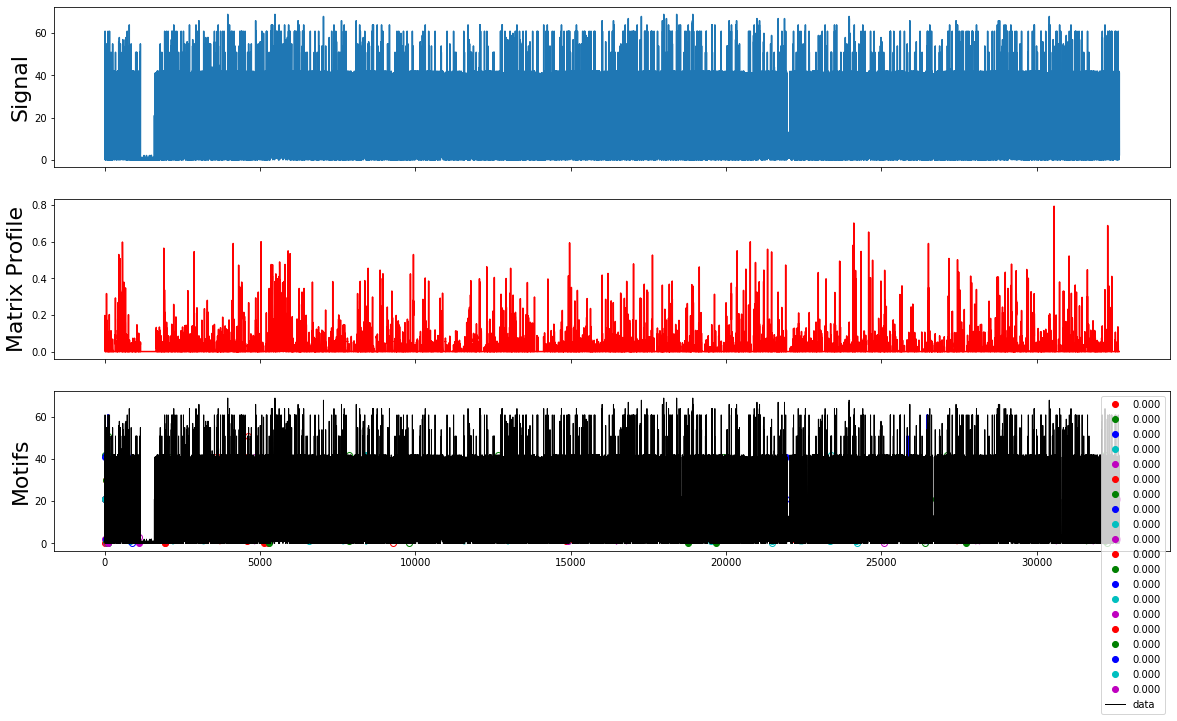

['break1', 'l1', 'c-alow', 'l1', 'c-bmed']
['break1', 'l1', 'c-alow', 'l1', 'c-bmed']
['break1', 'l1', 'c-alow', 'l1', 'c-bmed']

['l1', 'c-bmed', 'l1', 'stop1', 'c-bmed']
['l1', 'c-bmed', 'l1', 'stop1', 'c-bmed']
['l1', 'c-bmed', 'l1', 'stop1', 'c-bmed']
['l1', 'c-bmed', 'l1', 'stop1', 'c-bmed']
['l1', 'c-bmed', 'l1', 'stop1', 'c-bmed']
['l1', 'c-bmed', 'l1', 'stop1', 'c-bmed']
['l1', 'c-bmed', 'l1', 'stop1', 'c-bmed']
['l1', 'c-bmed', 'l1', 'stop1', 'c-bmed']
['l1', 'c-bmed', 'l1', 'stop1', 'c-bmed']
['l1', 'c-bmed', 'l1', 'stop1', 'c-bmed']
['l1', 'c-bmed', 'l1', 'stop1', 'c-bmed']
['l1', 'c-bmed', 'l1', 'stop1', 'c-bmed']

['stop1', 'c-bmed', 'v1', 'l1', 'c-bmed']
['stop1', 'c-bmed', 'v1', 'l1', 'c-bmed']

['l1', 'c-bmed', 'l1', 'c-bmed', 'break1']
['l1', 'c-bmed', 'l1', 'c-bmed', 'break1']
['l1', 'c-bmed', 'l1', 'c-bmed', 'break1']
['l1', 'c-bmed', 'l1', 'c-bmed', 'break1']
['l1', 'c-bmed', 'l1', 'c-bmed', 'break1']
['l1', 'c-bmed', 'l1', 'c-bmed', 'break1']
['l1', 'c-bmed', 'l1',

In [245]:
get_exact_patterns(sax_o2)

## Testing

In [246]:
df = s2.copy()
df['category2'][df['category2']=='communal'] = 'z'
df['category'] = df['category2'].apply(lambda x: x[0])
users1 = []
actions1 = []
users = np.array(df.userID.tolist())
sessions = np.array(df.session.tolist())
for i in range(1,len(users)):
    if users[i] != users[i-1]:
        actions1.append('stop')
        users1.append(users1[-1])
    elif sessions[i] != sessions[i-1]:
        actions1.append('break')
        users1.append(users1[-1])
    actions1.append(df.category[i])
    users1.append(users[i])
actions_new = pd.DataFrame({'userID':users1, 'actions':actions1})

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [314]:
my_list = []
for name, groups in actions_new.groupby('userID'):
    user_list = [['0',1]]
    cnt_list = 0
    category = groups.actions.tolist()
    for i in range(0,len(category)):
        if category[i] == user_list[cnt_list][0]:
            user_list[cnt_list][1]+=1
        else:                    
            '''
            if user_list[cnt_list][0] == 'c':
                if user_list[cnt_list][1] >= abin[2]:
                    user_list[cnt_list][1] = '-chigh'
                elif user_list[cnt_list][1] >= abin[0]:
                    user_list[cnt_list][1] = '-bmed'
                else:
                    user_list[cnt_list][1] = '-alow'
            '''
            user_list.append([category[i],1])
            cnt_list+=1

    my_list.append(user_list[1:])

In [289]:
my_list[:5]

[[['c', 20]],
 [['c', 9], ['stop', 1]],
 [['c', 110], ['stop', 1]],
 [['c', 21], ['l', 2], ['c', 4], ['stop', 1]],
 [['c', 6], ['l', 1], ['c', 14], ['stop', 1]]]

In [257]:
all1.category.value_counts()

c    2523660
v      65237
e      45947
l      34486
s      17205
z       8131
p       4146
Name: category, dtype: int64

In [298]:
s2.category2.value_counts()

classify            9223
exploring            165
view discussions     121
learning              94
socialize             16
communal               7
personal               5
Name: category2, dtype: int64

In [299]:
len(my_list)

61

In [315]:
labl = []
for i in range(0,len(my_list)):
    for j in range(0,len(my_list[i])):
        if my_list[i][j][0] == 'c':
            labl.append(10000+my_list[i][j][1])
        elif my_list[i][j][0] == 'v':
            labl.append(20000+my_list[i][j][1])
        elif my_list[i][j][0] == 'e':
            labl.append(30000+my_list[i][j][1])
        elif my_list[i][j][0] == 'l':
            labl.append(40000+my_list[i][j][1])
        elif my_list[i][j][0] == 's':
            labl.append(50000+my_list[i][j][1])
        elif my_list[i][j][0] == 'z':
            labl.append(60000+my_list[i][j][1])
        elif my_list[i][j][0] == 'p':
            labl.append(70000+my_list[i][j][1])
        elif my_list[i][j][0] == 'break':
            labl.append(15000+my_list[i][j][1])
        elif my_list[i][j][0] == 'stop':
            labl.append(90000+my_list[i][j][1])

In [316]:
labl

[10020,
 10009,
 90001,
 10110,
 90001,
 10021,
 40002,
 10004,
 90001,
 10006,
 40001,
 10014,
 90001,
 11104,
 30013,
 20001,
 30021,
 15001,
 30086,
 70001,
 20004,
 50004,
 30001,
 90001,
 10010,
 30003,
 10011,
 50004,
 10008,
 40001,
 10003,
 20003,
 50001,
 20004,
 50002,
 90001,
 10029,
 40001,
 90001,
 10033,
 20001,
 10008,
 20001,
 10009,
 20001,
 10005,
 20001,
 10015,
 30001,
 10004,
 20001,
 10051,
 30001,
 10007,
 30001,
 10002,
 90001,
 10028,
 15001,
 10018,
 15001,
 10017,
 20002,
 90001,
 10024,
 90001,
 10025,
 90001,
 10002,
 20001,
 30001,
 10006,
 20001,
 30001,
 10026,
 60001,
 15001,
 10007,
 15001,
 10021,
 40001,
 15001,
 40001,
 90001,
 10248,
 70001,
 15001,
 10070,
 90001,
 10001,
 30001,
 10001,
 30001,
 10014,
 40001,
 10001,
 30001,
 10009,
 20001,
 40001,
 10004,
 40002,
 10001,
 30001,
 40001,
 10015,
 40001,
 10001,
 40001,
 30001,
 10009,
 30002,
 10009,
 40001,
 10001,
 30001,
 10005,
 50002,
 30001,
 10004,
 40001,
 10001,
 30001,
 10004,
 40002,


In [317]:
for i in range(0,len(my_list)):
    my_list[i] = ["".join([str(k) for k in j]) for j in my_list[i]]

print("My list:")
print(my_list[:10])
#users = []
#for names,groups in df.groupby('userID'):
#    users.append(names)

My list:
[['c20'], ['c9', 'stop1'], ['c110', 'stop1'], ['c21', 'l2', 'c4', 'stop1'], ['c6', 'l1', 'c14', 'stop1'], ['c1104', 'e13', 'v1', 'e21', 'break1', 'e86', 'p1', 'v4', 's4', 'e1', 'stop1'], ['c10', 'e3', 'c11', 's4', 'c8', 'l1', 'c3', 'v3', 's1', 'v4', 's2', 'stop1'], ['c29', 'l1', 'stop1'], ['c33', 'v1', 'c8', 'v1', 'c9', 'v1', 'c5', 'v1', 'c15', 'e1', 'c4', 'v1', 'c51', 'e1', 'c7', 'e1', 'c2', 'stop1'], ['c28', 'break1', 'c18', 'break1', 'c17', 'v2', 'stop1']]


In [318]:
print("Start encoding....")
for i in range(0, len(my_list)):
    for j in range(0, len(my_list[i])):
        if re.match('c',my_list[i][j]):
            if int(re.findall('\d+',my_list[i][j])[0]) >= bins2[2]:
                my_list[i][j] = re.sub('\d+','-chigh', my_list[i][j])
            elif int(re.findall('\d+',my_list[i][j])[0]) >= bins2[0]:
                my_list[i][j] = re.sub('\d+','-bmed', my_list[i][j])
            else:
                my_list[i][j] = re.sub('\d+','-alow', my_list[i][j])

print(my_list[:10])

Start encoding....
[['c-bmed'], ['c-bmed', 'stop1'], ['c-chigh', 'stop1'], ['c-bmed', 'l2', 'c-bmed', 'stop1'], ['c-bmed', 'l1', 'c-bmed', 'stop1'], ['c-chigh', 'e13', 'v1', 'e21', 'break1', 'e86', 'p1', 'v4', 's4', 'e1', 'stop1'], ['c-bmed', 'e3', 'c-bmed', 's4', 'c-bmed', 'l1', 'c-alow', 'v3', 's1', 'v4', 's2', 'stop1'], ['c-bmed', 'l1', 'stop1'], ['c-chigh', 'v1', 'c-bmed', 'v1', 'c-bmed', 'v1', 'c-bmed', 'v1', 'c-bmed', 'e1', 'c-bmed', 'v1', 'c-chigh', 'e1', 'c-bmed', 'e1', 'c-alow', 'stop1'], ['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed', 'v2', 'stop1']]


In [319]:
actions = []
for i in my_list:
    actions.append(",".join(i))

#df_temp = pd.DataFrame({'userID':users, 'actions':actions})
flat_list_df = [item for sublist in actions for item in sublist.split(",")]
print("Sample activities...")
print(flat_list_df[:20])

Sample activities...
['c-bmed', 'c-bmed', 'stop1', 'c-chigh', 'stop1', 'c-bmed', 'l2', 'c-bmed', 'stop1', 'c-bmed', 'l1', 'c-bmed', 'stop1', 'c-chigh', 'e13', 'v1', 'e21', 'break1', 'e86', 'p1']


In [320]:
len(flat_list_df)

579

In [331]:
lbls = []
for i in range(0, len(flat_list_df)):
    if re.match('c-chigh',flat_list_df[i]):
            lbls.append(3)
    elif re.match('c-bmed',flat_list_df[i]):
            lbls.append(2)
    elif re.match('c-alow',flat_list_df[i]):
            lbls.append(1)
    else:
        if re.match('v',flat_list_df[i]):
            lbls.append(200+int(re.findall('\d+',flat_list_df[i])[0]))
        elif re.match('e',flat_list_df[i]):
            lbls.append(300+int(re.findall('\d+',flat_list_df[i])[0]))
        elif re.match('l',flat_list_df[i]):
            lbls.append(400+int(re.findall('\d+',flat_list_df[i])[0]))
        elif re.match('s',flat_list_df[i]):
            lbls.append(500+int(re.findall('\d+',flat_list_df[i])[0]))
        elif re.match('z',flat_list_df[i]):
            lbls.append(600+int(re.findall('\d+',flat_list_df[i])[0]))
        elif re.match('p',flat_list_df[i]):
            lbls.append(700+int(re.findall('\d+',flat_list_df[i])[0]))
        elif re.match('break',flat_list_df[i]):
            lbls.append(100+int(re.findall('\d+',flat_list_df[i])[0]))
        elif re.match('stop',flat_list_df[i]):
            lbls.append(800+int(re.findall('\d+',flat_list_df[i])[0]))

In [333]:
len(lbls)

579

In [321]:
#lbl = LabelEncoder() 
#lbl.fit(flat_list_df)
#actions_lbl = [lbl.transform(i.split(",")) for i in actions]
#flat_lbls_df = [item for sublist in actions_lbl for item in sublist]

In [322]:
len(labl)

579

In [323]:
lbl = LabelEncoder() 
lbl.fit(labl)

LabelEncoder()

In [324]:
get_integer_mapping(lbl)

{10001: 0,
 10002: 1,
 10003: 2,
 10004: 3,
 10005: 4,
 10006: 5,
 10007: 6,
 10008: 7,
 10009: 8,
 10010: 9,
 10011: 10,
 10013: 11,
 10014: 12,
 10015: 13,
 10016: 14,
 10017: 15,
 10018: 16,
 10019: 17,
 10020: 18,
 10021: 19,
 10023: 20,
 10024: 21,
 10025: 22,
 10026: 23,
 10028: 24,
 10029: 25,
 10030: 26,
 10031: 27,
 10033: 28,
 10034: 29,
 10035: 30,
 10037: 31,
 10039: 32,
 10040: 33,
 10041: 34,
 10042: 35,
 10043: 36,
 10044: 37,
 10046: 38,
 10047: 39,
 10049: 40,
 10051: 41,
 10053: 42,
 10059: 43,
 10060: 44,
 10062: 45,
 10064: 46,
 10066: 47,
 10069: 48,
 10070: 49,
 10073: 50,
 10080: 51,
 10083: 52,
 10084: 53,
 10087: 54,
 10089: 55,
 10091: 56,
 10095: 57,
 10101: 58,
 10102: 59,
 10104: 60,
 10110: 61,
 10111: 62,
 10114: 63,
 10117: 64,
 10127: 65,
 10147: 66,
 10148: 67,
 10152: 68,
 10155: 69,
 10194: 70,
 10211: 71,
 10216: 72,
 10233: 73,
 10242: 74,
 10248: 75,
 10398: 76,
 10407: 77,
 11104: 78,
 15001: 79,
 20001: 80,
 20002: 81,
 20003: 82,
 20004: 83,
 2

In [325]:
sax_df = sax_via_window(lbl.transform(labl),5,5,5,"none", 0.1)

In [326]:
most_common([sax_df, flat_list_df], 20)

Total Number of patterns: 3
bebea, number of occurances:  21
['c-bmed', 'e3', 'c-bmed', 's4', 'c-bmed']
['c-bmed', 'stop1', 'c-bmed', 'stop1', 'c-bmed']
['c-chigh', 'stop1', 'c-chigh', 'stop1', 'c-bmed']
['c-bmed', 's4', 'c-bmed', 'l1', 'c-alow']
['c-bmed', 'stop1', 'c-bmed', 'l1', 'c-alow']
['c-bmed', 'break1', 'c-bmed', 'break1', 'c-alow']

dadad, number of occurances:  49
['v1', 'c-bmed', 'v1', 'c-bmed', 'v1']
['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']
['v1', 'c-bmed', 'break1', 'c-alow', 'break1']
['v1', 'c-bmed', 'v1', 'c-bmed', 'v1']
['break1', 'c-bmed', 'break1', 'c-alow', 'break1']
['break1', 'c-alow', 'break1', 'c-bmed', 'v1']

beaeb, number of occurances:  22
['c-bmed', 'v1', 'c-bmed', 'v1', 'c-bmed']
['c-bmed', 'l1', 'c-alow', 'break1', 'c-bmed']
['c-bmed', 'break1', 'c-bmed', 'v5', 'c-bmed']
['c-bmed', 'l1', 'c-alow', 'e1', 'c-bmed']
['c-bmed', 'l1', 'c-alow', 'v1', 'c-bmed']
['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']



In [327]:
most_common([sax_df, labl], 20)

Total Number of patterns: 3
bebea, number of occurances:  21
[10010, 30003, 10011, 50004, 10008]
[10020, 90001, 10020, 90001, 10005]
[10073, 90001, 10039, 90001, 10017]
[10011, 50004, 10008, 40001, 10003]
[10019, 90001, 10024, 40001, 10002]
[10013, 15001, 10020, 15001, 10002]

dadad, number of occurances:  49
[20001, 10008, 20001, 10009, 20001]
[15001, 10013, 15001, 10020, 15001]
[20001, 10009, 15001, 10003, 15001]
[20001, 10009, 20001, 10005, 20001]
[15001, 10020, 15001, 10002, 15001]
[15001, 10003, 15001, 10011, 20001]

beaeb, number of occurances:  22
[10009, 20001, 10005, 20001, 10015]
[10028, 40001, 10003, 15001, 10020]
[10010, 15001, 10009, 20005, 10011]
[10014, 40001, 10001, 30001, 10009]
[10024, 40001, 10002, 20001, 10029]
[10020, 15001, 10006, 15001, 10013]



In [334]:
lbl = LabelEncoder() 
lbl.fit(lbls)

LabelEncoder()

In [335]:
get_integer_mapping(lbl)

{1: 0,
 2: 1,
 3: 2,
 101: 3,
 201: 4,
 202: 5,
 203: 6,
 204: 7,
 205: 8,
 206: 9,
 208: 10,
 209: 11,
 301: 12,
 302: 13,
 303: 14,
 313: 15,
 321: 16,
 386: 17,
 401: 18,
 402: 19,
 501: 20,
 502: 21,
 504: 22,
 601: 23,
 701: 24}

In [336]:
sax_df = sax_via_window(lbl.transform(lbls),5,5,5,"none", 0.1)

In [337]:
most_common([sax_df, flat_list_df], 20)

Total Number of patterns: 2
bebeb, number of occurances:  28
['c-bmed', 'l2', 'c-bmed', 'stop1', 'c-bmed']
['c-bmed', 'stop1', 'c-bmed', 'stop1', 'c-bmed']
['c-bmed', 'stop1', 'c-bmed', 'stop1', 'c-bmed']
['c-bmed', 'stop1', 'c-bmed', 'l1', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']
['c-bmed', 'stop1', 'c-bmed', 'stop1', 'c-bmed']

dadad, number of occurances:  38
['v1', 'c-bmed', 'v1', 'c-bmed', 'v1']
['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']
['stop1', 'c-bmed', 'stop1', 'c-bmed', 'stop1']
['v1', 'c-bmed', 'v1', 'c-bmed', 'v1']
['break1', 'c-alow', 'break1', 'c-alow', 'break1']
['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']



In [344]:
def get_patterns_bins1(df, abin, size = 5):
    df['category2'][df['category2']=='communal'] = 'z'
    df['category'] = df['category2'].apply(lambda x: x[0])
    users1 = []
    actions1 = []
    users = np.array(df.userID.tolist())
    sessions = np.array(df.session.tolist())
    for i in range(1,len(users)):
        if users[i] != users[i-1]:
            actions1.append('stop')
            users1.append(users1[-1])
        elif sessions[i] != sessions[i-1]:
            actions1.append('break')
            users1.append(users1[-1])
        actions1.append(df.category[i])
        users1.append(users[i])
    actions_new = pd.DataFrame({'userID':users1, 'actions':actions1})
    
    
    my_list = []
    for name, groups in actions_new.groupby('userID'):
        user_list = [['0',1]]
        cnt_list = 0
        category = groups.actions.tolist()
        for i in range(0,len(category)):
            if category[i] == user_list[cnt_list][0]:
                user_list[cnt_list][1]+=1
            else:                    
                '''
                if user_list[cnt_list][0] == 'c':
                    if user_list[cnt_list][1] >= abin[2]:
                        user_list[cnt_list][1] = '-chigh'
                    elif user_list[cnt_list][1] >= abin[0]:
                        user_list[cnt_list][1] = '-bmed'
                    else:
                        user_list[cnt_list][1] = '-alow'
                '''
                user_list.append([category[i],1])
                cnt_list+=1
       
        my_list.append(user_list[1:])
        
    for i in range(0,len(my_list)):
        my_list[i] = ["".join([str(k) for k in j]) for j in my_list[i]]

    #users = []
    #for names,groups in df.groupby('userID'):
    #    users.append(names)
    print("Start encoding....")
    for i in range(0, len(my_list)):
        for j in range(0, len(my_list[i])):
            if re.match('c',my_list[i][j]):
                if int(re.findall('\d+',my_list[i][j])[0]) >= abin[2]:
                    my_list[i][j] = re.sub('\d+','-chigh', my_list[i][j])
                elif int(re.findall('\d+',my_list[i][j])[0]) >= abin[0]:
                    my_list[i][j] = re.sub('\d+','-bmed', my_list[i][j])
                else:
                    my_list[i][j] = re.sub('\d+','-alow', my_list[i][j])
    print("Done encoding.")
    
    actions = []
    for i in my_list:
        actions.append(",".join(i))
    
    #df_temp = pd.DataFrame({'userID':users, 'actions':actions})
    flat_list_df = [item for sublist in actions for item in sublist.split(",")]
    print("Get labels...")
    
    lbls = []
    for i in range(0, len(flat_list_df)):
        if re.match('c-chigh',flat_list_df[i]):
                lbls.append(3)
        elif re.match('c-bmed',flat_list_df[i]):
                lbls.append(2)
        elif re.match('c-alow',flat_list_df[i]):
                lbls.append(1)
        else:
            if re.match('v',flat_list_df[i]):
                lbls.append(200+int(re.findall('\d+',flat_list_df[i])[0]))
            elif re.match('e',flat_list_df[i]):
                lbls.append(300+int(re.findall('\d+',flat_list_df[i])[0]))
            elif re.match('l',flat_list_df[i]):
                lbls.append(400+int(re.findall('\d+',flat_list_df[i])[0]))
            elif re.match('s',flat_list_df[i]):
                lbls.append(500+int(re.findall('\d+',flat_list_df[i])[0]))
            elif re.match('z',flat_list_df[i]):
                lbls.append(600+int(re.findall('\d+',flat_list_df[i])[0]))
            elif re.match('p',flat_list_df[i]):
                lbls.append(700+int(re.findall('\d+',flat_list_df[i])[0]))
            elif re.match('break',flat_list_df[i]):
                lbls.append(100+int(re.findall('\d+',flat_list_df[i])[0]))
            elif re.match('stop',flat_list_df[i]):
                lbls.append(800+int(re.findall('\d+',flat_list_df[i])[0]))            
    
    lbl = LabelEncoder() 
    lbl.fit(lbls)
    #actions_lbl = [lbl.transform(i.split(",")) for i in actions]
    #flat_lbls_df = [item for sublist in actions_lbl for item in sublist]
    flat_lbls_df = lbl.transform(lbls)
    print("Labels done.")
    
    print("Start SAX transformation...")
    sax_df = sax_via_window(flat_lbls_df,size,size,size,"none", 0.01)
    print("SAX transformation done.")
    return [sax_df,flat_list_df]

In [345]:
sax_s1 = get_patterns_bins1(s1, bins1)

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Start encoding....
Done encoding.
Get labels...
Labels done.
Start SAX transformation...
SAX transformation done.


In [347]:
most_common(sax_s1, 20)

Total Number of patterns: 3
bebeb, number of occurances:  25
['c-bmed', 'stop1', 'c-alow', 'l2', 'c-alow']
['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']
['c-alow', 'l1', 'c-alow', 'l3', 'c-alow']
['c-bmed', 's4', 'c-bmed', 's2', 'c-bmed']
['c-alow', 'stop1', 'c-alow', 'l1', 'c-bmed']
['c-chigh', 'stop1', 'c-bmed', 'l2', 'c-bmed']

eadad, number of occurances:  22
['stop1', 'c-alow', 'l2', 'c-alow', 'l5']
['stop1', 'c-chigh', 'l1', 'c-chigh', 'l1']
['stop1', 'c-alow', 'l1', 'c-bmed', 'l2']
['l5', 'v3', 'l1', 'v4', 'l1']
['stop1', 'c-alow', 'l1', 'c-bmed', 'l1']
['e2', 'c-bmed', 'e1', 'c-bmed', 'e1']

dadad, number of occurances:  25
['l1', 'c-chigh', 'l1', 'c-bmed', 'l1']
['e1', 'c-alow', 'e1', 'c-bmed', 'e1']
['stop1', 'c-chigh', 'stop1', 'c-bmed', 'stop1']
['l1', 'c-bmed', 'l1', 'c-alow', 'l1']
['l1', 'c-bmed', 'l1', 'c-chigh', 'l1']
['stop1', 'c-bmed', 'stop1', 'c-chigh', 'stop1']



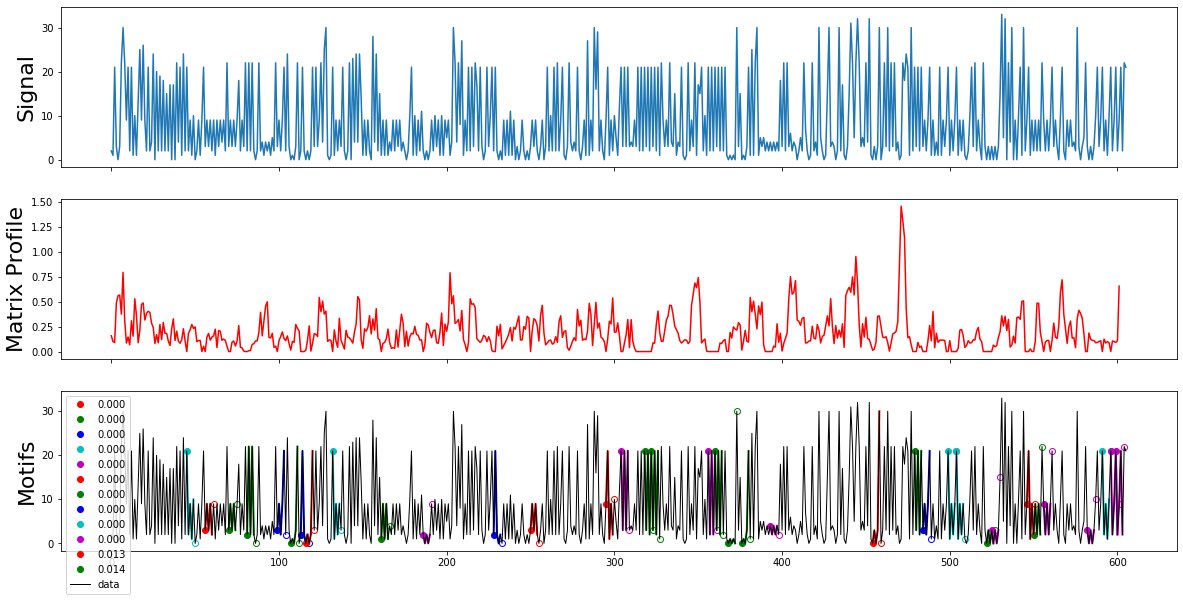

['c-chigh', 'l1', 'c-chigh', 'l1', 'c-bmed']
['c-chigh', 'l1', 'c-chigh', 'l1', 'c-bmed']

['c-chigh', 'l1', 'c-chigh', 'l1', 'c-chigh']
['c-bmed', 'v1', 'c-bmed', 'v1', 'c-bmed']
['c-alow', 'l1', 'c-alow', 'l1', 'c-alow']
['break1', 'c-alow', 'break1', 'c-alow', 'break1']
['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']
['c-bmed', 'l1', 'c-bmed', 'l1', 'c-bmed']

['c-bmed', 'stop1', 'c-bmed', 'break1', 'c-bmed']
['c-bmed', 'stop1', 'c-bmed', 'break1', 'c-bmed']

['stop1', 'c-alow', 'l1', 'c-bmed', 'l1']
['stop1', 'c-alow', 'l1', 'c-bmed', 'l1']
['stop1', 'c-alow', 'l1', 'c-bmed', 'l1']

['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']
['stop1', 'c-chigh', 'stop1', 'c-chigh', 'stop1']
['stop1', 'c-bmed', 'stop1', 'c-bmed', 'stop1']
['e1', 'c-bmed', 'e1', 'c-bmed', 'e1']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']
['l1', 'c-bmed', 'l1', 'c-bmed', 'l1']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

['l1', 'stop1', 'c-alow', 'l1', 'c-bmed']
['l1', 'stop1', 'c-alow

In [348]:
get_exact_patterns(sax_s1)

In [349]:
sax_o1 = get_patterns_bins1(o1, bins1)

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mistr\Anaconda3\lib\site-packages\pandas\core\generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This

Start encoding....
Done encoding.
Get labels...
Labels done.
Start SAX transformation...
SAX transformation done.


In [352]:
most_common(sax_o1, 1000)

Total Number of patterns: 10
bbbeb, number of occurances:  1515
['c-chigh', 'break1', 'v1', 'stop1', 'c-chigh']
['c-bmed', 'break1', 'c-bmed', 'stop1', 'c-chigh']
['c-alow', 'break1', 'c-bmed', 'stop1', 'c-chigh']
['c-chigh', 'break1', 'c-alow', 'stop1', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 'stop1', 'c-bmed']
['c-alow', 'break1', 'c-chigh', 'stop1', 'c-bmed']

dadad, number of occurances:  3622
['stop1', 'c-chigh', 'stop1', 'c-bmed', 'stop1']
['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']
['e1', 'c-alow', 'e1', 'c-alow', 'e1']
['stop1', 'c-chigh', 'stop1', 'c-bmed', 'stop1']
['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']
['e1', 'c-alow', 'e1', 'c-alow', 'e1']

bebeb, number of occurances:  4859
['c-chigh', 'stop1', 'c-bmed', 'stop1', 'c-chigh']
['c-chigh', 'stop1', 'c-bmed', 'stop1', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']
['c-alow', 'l2', 'c-alow', 'l1', 'c-bmed']
['c-chigh', 'stop1', 'c-bmed', 'stop1', 'c-chigh']
['c-bmed', 'l1', 'c-chigh', '

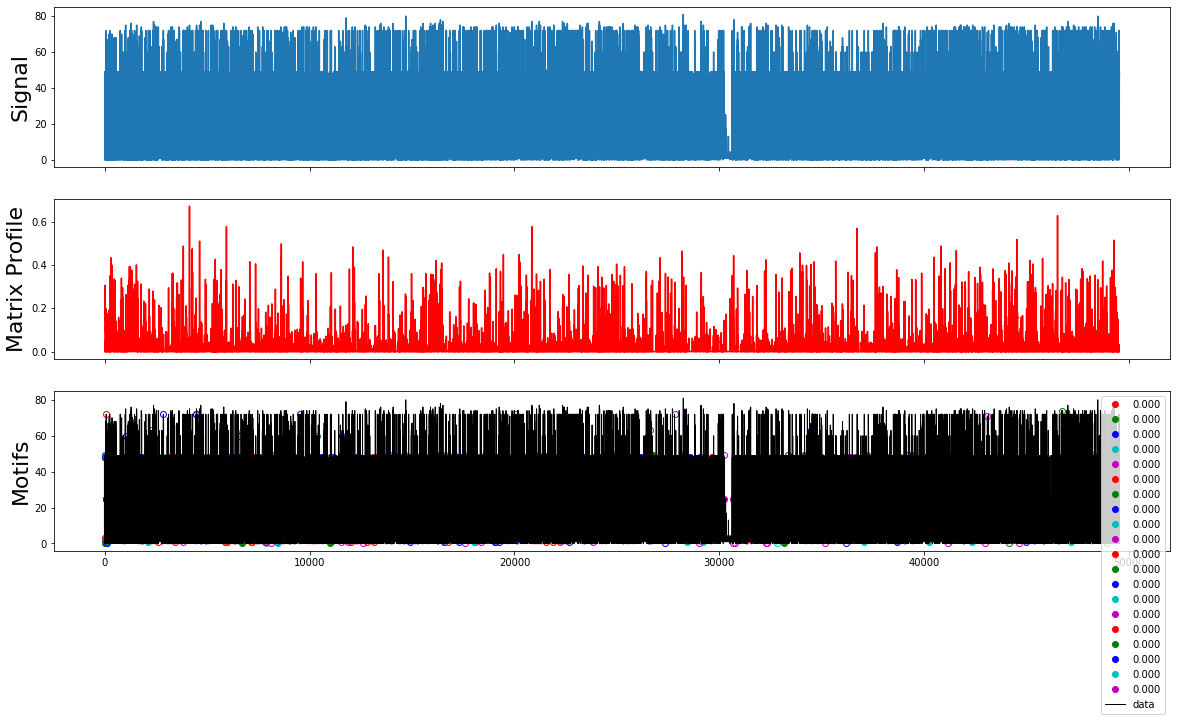

['stop1', 'c-chigh', 'break1', 'v1', 'stop1']
['stop1', 'c-chigh', 'break1', 'v1', 'stop1']

['v1', 'stop1', 'c-chigh', 'stop1', 'c-bmed']
['v1', 'stop1', 'c-chigh', 'stop1', 'c-bmed']
['v1', 'stop1', 'c-chigh', 'stop1', 'c-bmed']
['v1', 'stop1', 'c-chigh', 'stop1', 'c-bmed']
['v1', 'stop1', 'c-chigh', 'stop1', 'c-bmed']
['v1', 'stop1', 'c-chigh', 'stop1', 'c-bmed']
['v1', 'stop1', 'c-chigh', 'stop1', 'c-bmed']
['v1', 'stop1', 'c-chigh', 'stop1', 'c-bmed']
['v1', 'stop1', 'c-chigh', 'stop1', 'c-bmed']
['v1', 'stop1', 'c-chigh', 'stop1', 'c-bmed']
['v1', 'stop1', 'c-chigh', 'stop1', 'c-bmed']
['v1', 'stop1', 'c-chigh', 'stop1', 'c-bmed']
['v1', 'stop1', 'c-chigh', 'stop1', 'c-bmed']
['v1', 'stop1', 'c-chigh', 'stop1', 'c-bmed']
['v1', 'stop1', 'c-chigh', 'stop1', 'c-bmed']
['v1', 'stop1', 'c-chigh', 'stop1', 'c-bmed']
['v1', 'stop1', 'c-chigh', 'stop1', 'c-bmed']
['v1', 'stop1', 'c-chigh', 'stop1', 'c-bmed']
['v1', 'stop1', 'c-chigh', 'stop1', 'c-bmed']
['v1', 'stop1', 'c-chigh', 'stop1

In [351]:
get_exact_patterns(sax_o1)

In [353]:
sax_s2 = get_patterns_bins1(s2, bins2)

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mistr\Anaconda3\lib\site-packages\pandas\core\generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This

Start encoding....
Done encoding.
Get labels...
Labels done.
Start SAX transformation...
SAX transformation done.


In [354]:
most_common(sax_s2)

Total Number of patterns: 0


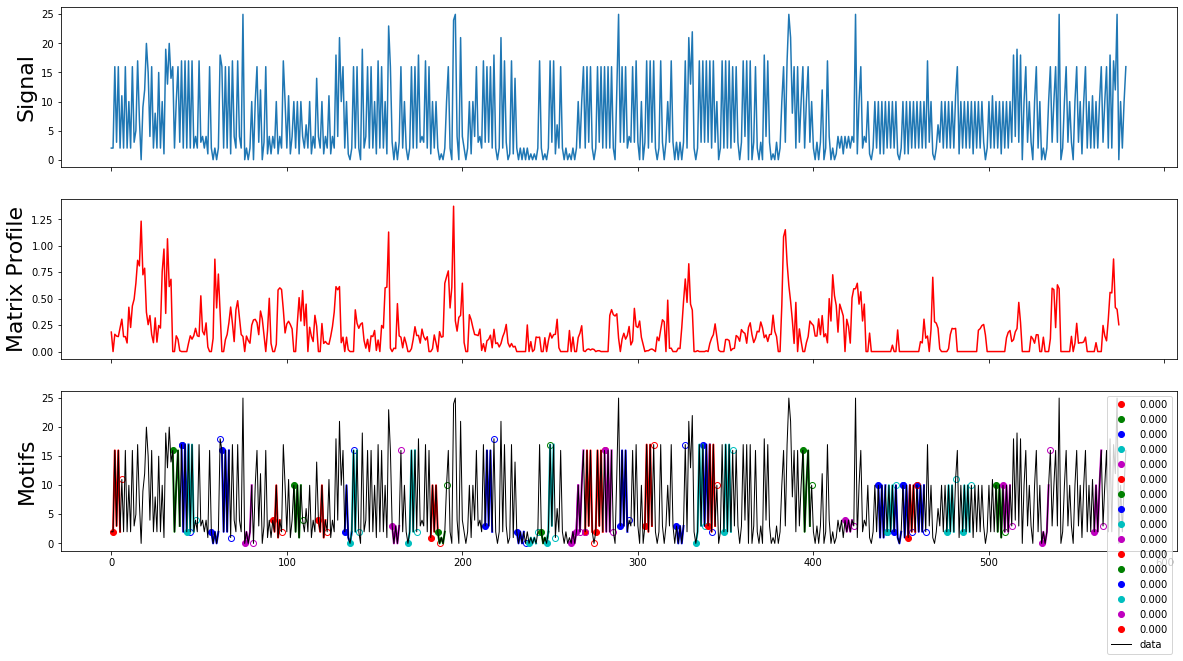

['c-bmed', 'stop1', 'c-chigh', 'stop1', 'c-bmed']
['c-bmed', 'stop1', 'c-chigh', 'stop1', 'c-bmed']
['c-bmed', 'stop1', 'c-chigh', 'stop1', 'c-bmed']

['stop1', 'c-bmed', 'l1', 'stop1', 'c-chigh']
['stop1', 'c-bmed', 'l1', 'stop1', 'c-chigh']

['v1', 'c-bmed', 'v1', 'c-bmed', 'v1']
['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']
['stop1', 'c-bmed', 'stop1', 'c-bmed', 'stop1']
['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']
['v1', 'c-chigh', 'v1', 'c-chigh', 'v1']
['l1', 'c-alow', 'l1', 'c-alow', 'l1']
['l1', 'c-alow', 'l1', 'c-alow', 'l1']
['l1', 'c-bmed', 'l1', 'c-bmed', 'l1']

['c-bmed', 'v1', 'c-bmed', 'v1', 'c-bmed']
['break1', 'c-alow', 'break1', 'c-alow', 'break1']
['c-bmed', 'v1', 'c-bmed', 'v1', 'c-bmed']
['c-bmed', 'l1', 'c-bmed', 'l1', 'c-bmed']
['c-bmed', 'l1', 'c-bmed', 'l1', 'c-bmed']
['c-bmed', 'l1', 'c-bmed', 'l1', 'c-bmed']

['break1', 'c-bmed', 'break1', 'c-bmed', 'l1']
['break1', 'c-bmed', 'break1', 'c-bmed',

In [355]:
get_exact_patterns(sax_s2)

In [356]:
sax_o2 = get_patterns_bins1(o2, bins2)

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mistr\Anaconda3\lib\site-packages\pandas\core\generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This

Start encoding....
Done encoding.
Get labels...
Labels done.
Start SAX transformation...
SAX transformation done.


In [357]:
most_common(sax_o2)

Total Number of patterns: 65
bebdb, number of occurances:  352
['c-chigh', 'stop1', 'c-bmed', 'e5', 'c-chigh']
['c-alow', 's4', 'v1', 'e2', 'c-alow']
['c-bmed', 'v1', 'c-bmed', 'break1', 'c-bmed']
['c-bmed', 'l1', 'c-chigh', 'e1', 'c-alow']
['v1', 's2', 'c-alow', 'e1', 'c-alow']
['c-alow', 'stop1', 'c-bmed', 'e1', 'c-bmed']

eacae, number of occurances:  162
['stop1', 'c-bmed', 'e5', 'c-chigh', 's2']
['s2', 'c-alow', 'e1', 'c-alow', 's2']
['l1', 'c-chigh', 'e1', 'c-alow', 'l1']
['l1', 'c-chigh', 'e1', 'c-alow', 's3']
['stop1', 'c-bmed', 'e1', 'c-bmed', 'stop1']
['stop1', 'c-chigh', 'e1', 'c-bmed', 'stop1']

eadad, number of occurances:  619
['z1', 'break1', 'l1', 'c-alow', 'l1']
['stop1', 'c-bmed', 'l1', 'c-bmed', 'l1']
['stop1', 'c-alow', 'l1', 'c-alow', 'l1']
['s1', 'c-alow', 'l1', 'c-bmed', 'l2']
['l1', 'c-bmed', 'e1', 'c-chigh', 'e1']
['l4', 'c-alow', 'l1', 'c-alow', 'l1']

beaeb, number of occurances:  613
['break1', 'l1', 'c-alow', 'l1', 'c-bmed']
['c-chigh', 'stop1', 'c-alow', '

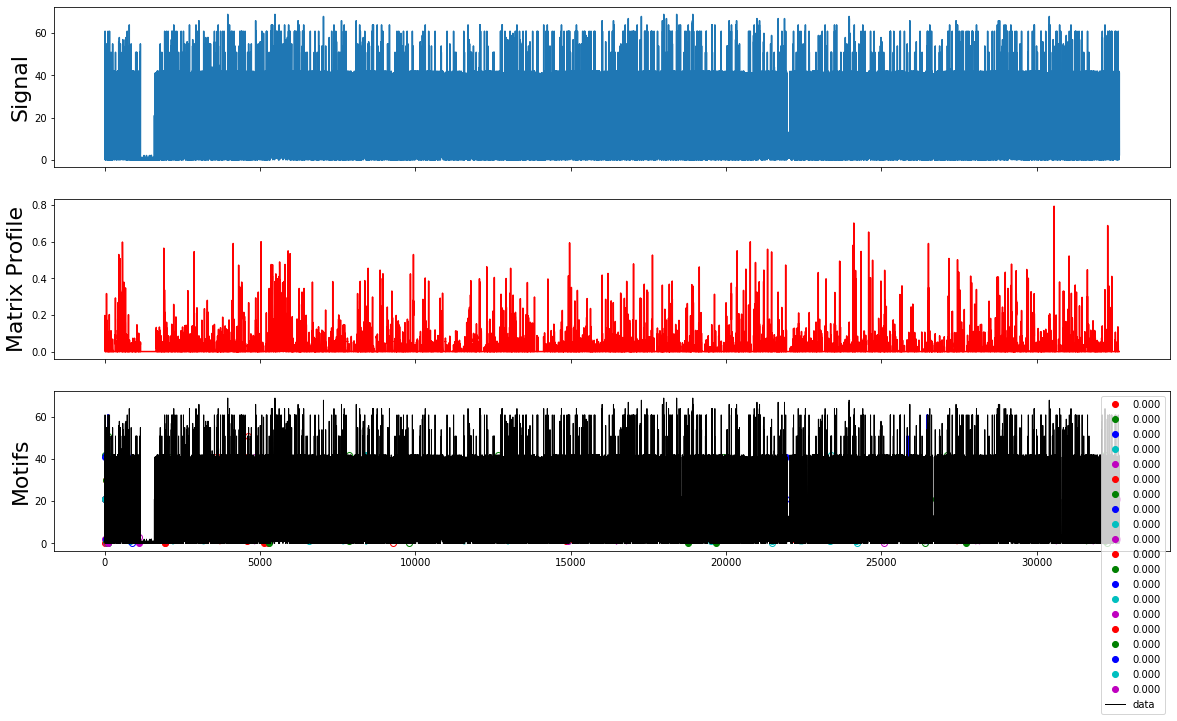

['break1', 'l1', 'c-alow', 'l1', 'c-bmed']
['break1', 'l1', 'c-alow', 'l1', 'c-bmed']
['break1', 'l1', 'c-alow', 'l1', 'c-bmed']

['l1', 'c-bmed', 'l1', 'stop1', 'c-bmed']
['l1', 'c-bmed', 'l1', 'stop1', 'c-bmed']
['l1', 'c-bmed', 'l1', 'stop1', 'c-bmed']
['l1', 'c-bmed', 'l1', 'stop1', 'c-bmed']
['l1', 'c-bmed', 'l1', 'stop1', 'c-bmed']
['l1', 'c-bmed', 'l1', 'stop1', 'c-bmed']
['l1', 'c-bmed', 'l1', 'stop1', 'c-bmed']
['l1', 'c-bmed', 'l1', 'stop1', 'c-bmed']
['l1', 'c-bmed', 'l1', 'stop1', 'c-bmed']
['l1', 'c-bmed', 'l1', 'stop1', 'c-bmed']
['l1', 'c-bmed', 'l1', 'stop1', 'c-bmed']
['l1', 'c-bmed', 'l1', 'stop1', 'c-bmed']

['stop1', 'c-bmed', 'v1', 'l1', 'c-bmed']
['stop1', 'c-bmed', 'v1', 'l1', 'c-bmed']

['l1', 'c-bmed', 'l1', 'c-bmed', 'break1']
['l1', 'c-bmed', 'l1', 'c-bmed', 'break1']
['l1', 'c-bmed', 'l1', 'c-bmed', 'break1']
['l1', 'c-bmed', 'l1', 'c-bmed', 'break1']
['l1', 'c-bmed', 'l1', 'c-bmed', 'break1']
['l1', 'c-bmed', 'l1', 'c-bmed', 'break1']
['l1', 'c-bmed', 'l1',

In [358]:
get_exact_patterns(sax_o2)

In [359]:
super_3 = pd.read_csv('./superusers_lvl3_2.csv')
other_3 = pd.read_csv('./other_lvl3_2.csv')
s3 = super_3[['userID','session','category2']]
o3 = other_3[['userID','session','category2']]

In [360]:
sax_s3 = get_patterns_bins1(s3, bins3)

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mistr\Anaconda3\lib\site-packages\pandas\core\generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This

Start encoding....
Done encoding.
Get labels...
Labels done.
Start SAX transformation...
SAX transformation done.


In [362]:
most_common(sax_s3, 20)

Total Number of patterns: 18
beaeb, number of occurances:  28
['c-chigh', 'v1', 'c-bmed', 'v1', 'c-chigh']
['e4', 'z1', 'e2', 'z1', 'e4']
['v5', 's1', 'v2', 's1', 'v4']
['e12', 'p1', 'e5', 'p1', 'e13']
['e3', 'z1', 'e1', 'z2', 'e2']
['c-chigh', 'l1', 'c-bmed', 'stop1', 'c-chigh']

aebeb, number of occurances:  38
['c-bmed', 'break1', 'c-chigh', 'break1', 'c-chigh']
['v2', 'p2', 'e5', 'p1', 'e2']
['e1', 'z1', 'e12', 'z1', 'e18']
['c-bmed', 'break1', 'c-chigh', 'break1', 'c-chigh']
['e1', 'p1', 'e11', 'p1', 'e11']
['e12', 'z1', 'e18', 'z2', 'e21']

dadae, number of occurances:  24
['break1', 'c-chigh', 'break1', 'c-chigh', 'v1']
['z2', 'e1', 'z1', 'e5', 'p1']
['e2', 'break1', 'e2', 'break1', 'e4']
['break1', 'c-chigh', 'break1', 'c-chigh', 'v1']
['s6', 'e2', 's1', 'e1', 'p1']
['e1', 'break1', 'e1', 'break1', 'e2']

bcbeb, number of occurances:  28
['c-chigh', 'v1', 'break1', 'v6', 'c-chigh']
['c-bmed', 'e1', 'c-alow', 'l1', 'c-alow']
['v1', 'e1', 'v1', 's1', 'v5']
['v1', 'e2', 'break1', 

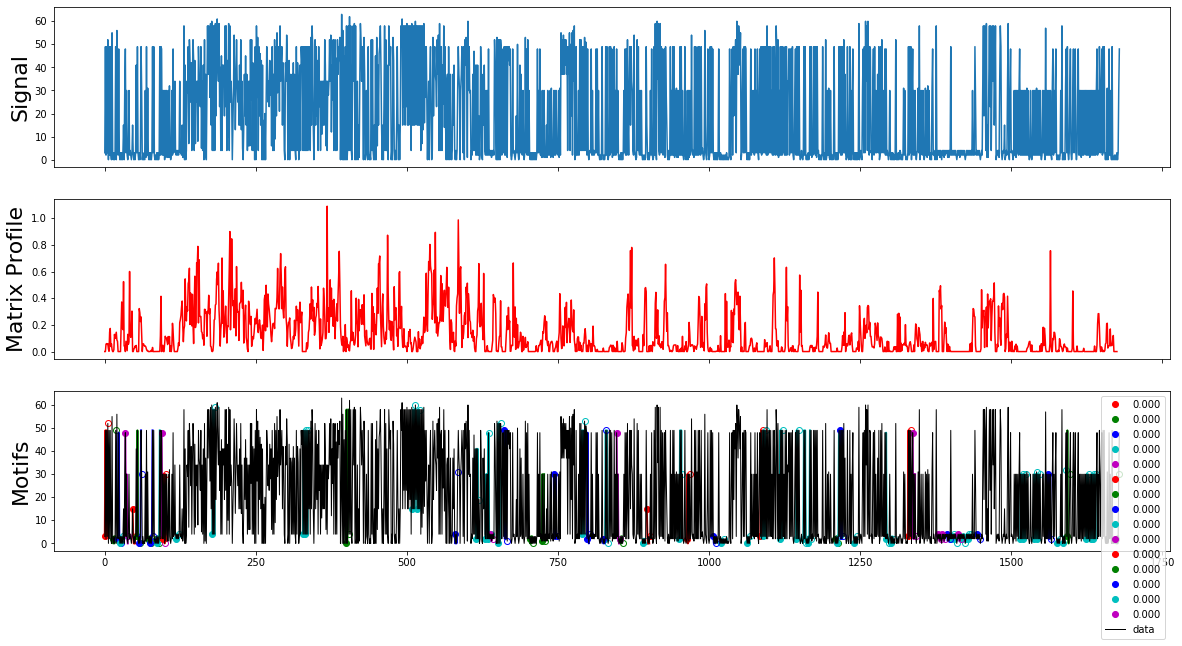

['c-chigh', 'v1', 'c-bmed', 'v1', 'c-chigh']
['c-chigh', 'v1', 'c-bmed', 'v1', 'c-chigh']
['c-chigh', 'v1', 'c-bmed', 'v1', 'c-chigh']

['c-bmed', 'break1', 'c-chigh', 'break1', 'c-chigh']
['c-bmed', 'break1', 'c-chigh', 'break1', 'c-chigh']
['c-bmed', 'break1', 'c-chigh', 'break1', 'c-chigh']
['c-bmed', 'break1', 'c-chigh', 'break1', 'c-chigh']
['c-bmed', 'break1', 'c-chigh', 'break1', 'c-chigh']
['c-bmed', 'break1', 'c-chigh', 'break1', 'c-chigh']
['c-bmed', 'break1', 'c-chigh', 'break1', 'c-chigh']

['c-bmed', 'stop1', 'c-chigh', 'break1', 'c-chigh']
['c-bmed', 'stop1', 'c-chigh', 'break1', 'c-chigh']

['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']
['c-bmed', 'e1', 'c-bmed', 'e1', 'c-bmed']
['e1', 'z1', 'e1', 'z1', 'e1']
['e1', 'v1', 'e1', 'v1', 'e1']
['e1', 'v1', 'e1', 'v1', 'e1']
['e2', 'z1', 'e2', 'z1', 'e2']
['e2', 'z1', 'e2', 'z1', 'e2']
['c-bmed', 's2', 'c-bmed', 's2', 'c-bmed']
['c-bmed', 'l1', 'c-bmed', 'l1', 'c-bmed']
['break1', 'v2', 'break1', 'v2', 'break1']
['e1', 

In [363]:
get_exact_patterns(sax_s3)

In [364]:
sax_o3 = get_patterns_bins1(o3, bins3)

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mistr\Anaconda3\lib\site-packages\pandas\core\generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This

Start encoding....
Done encoding.
Get labels...
Labels done.
Start SAX transformation...
SAX transformation done.


In [365]:
most_common(sax_o3)

Total Number of patterns: 76
dbebb, number of occurances:  174
['e5', 'c-alow', 'stop1', 'c-chigh', 'break1']
['e2', 'c-alow', 's2', 'v1', 'c-alow']
['e2', 'c-chigh', 'stop1', 'c-chigh', 'v1']
['e1', 'c-bmed', 'l1', 'c-bmed', 'v1']
['e1', 'c-bmed', 'l1', 'c-bmed', 'break1']
['e5', 'c-alow', 'l2', 'c-alow', 'v1']

aebbe, number of occurances:  102
['c-alow', 'stop1', 'c-chigh', 'break1', 'l2']
['c-alow', 'l1', 'c-chigh', 'break1', 'l2']
['c-bmed', 'e1', 'c-chigh', 'break1', 'e1']
['c-alow', 'l2', 'v4', 'break1', 'l1']
['c-alow', 'l1', 'v1', 'break1', 'l1']
['c-alow', 'l2', 'c-bmed', 'break1', 'l2']

bbebd, number of occurances:  173
['c-chigh', 'break1', 'l2', 'c-chigh', 'e3']
['v1', 'c-alow', 'stop1', 'c-bmed', 'e1']
['v1', 'c-alow', 'l1', 'c-alow', 'e4']
['break1', 'c-bmed', 'stop1', 'c-chigh', 'e1']
['break1', 'c-chigh', 'stop1', 'c-alow', 'e1']
['break1', 'c-bmed', 'l1', 'c-alow', 'e4']

bebdb, number of occurances:  504
['break1', 'l2', 'c-chigh', 'e3', 'c-chigh']
['c-bmed', 'v1', 

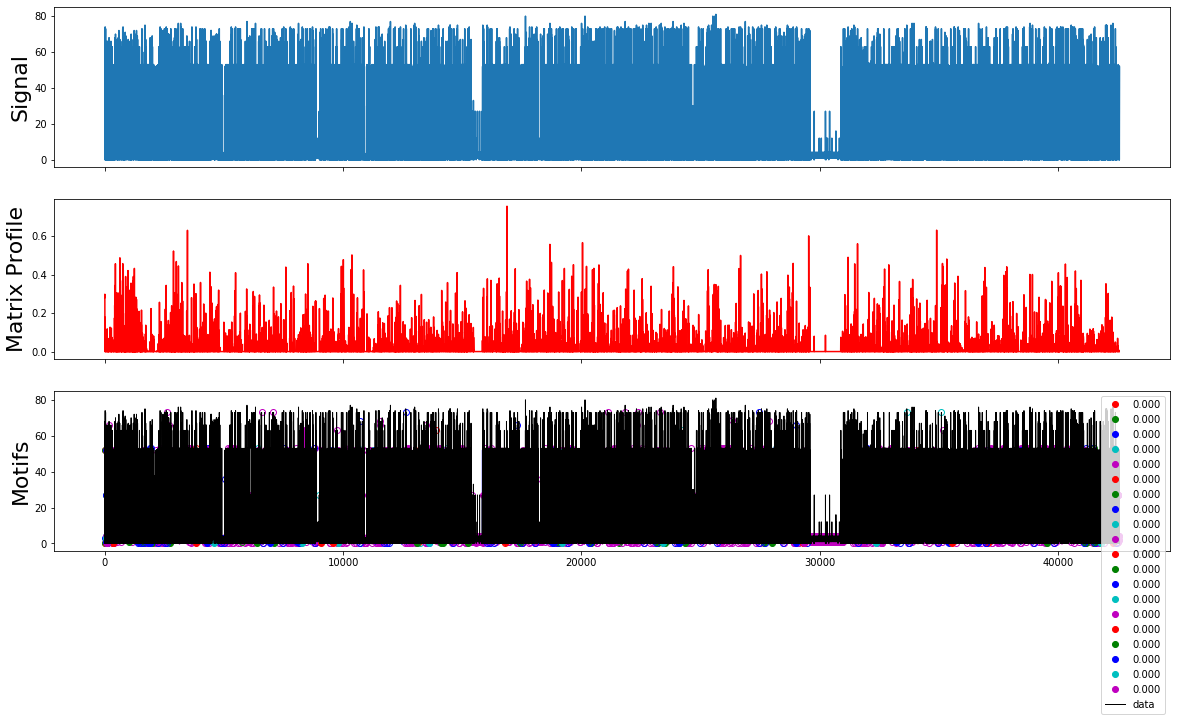

['stop1', 'c-bmed', 'break1', 'c-bmed', 'e1']
['stop1', 'c-bmed', 'break1', 'c-bmed', 'e1']
['stop1', 'c-bmed', 'break1', 'c-bmed', 'e1']
['stop1', 'c-bmed', 'break1', 'c-bmed', 'e1']
['stop1', 'c-bmed', 'break1', 'c-bmed', 'e1']
['stop1', 'c-bmed', 'break1', 'c-bmed', 'e1']
['stop1', 'c-bmed', 'break1', 'c-bmed', 'e1']
['stop1', 'c-bmed', 'break1', 'c-bmed', 'e1']

['break1', 'c-bmed', 'v1', 'c-chigh', 'l1']
['break1', 'c-bmed', 'v1', 'c-chigh', 'l1']

['c-chigh', 'l1', 'stop1', 'c-bmed', 'stop1']
['c-chigh', 'l1', 'stop1', 'c-bmed', 'stop1']
['c-chigh', 'l1', 'stop1', 'c-bmed', 'stop1']
['c-chigh', 'l1', 'stop1', 'c-bmed', 'stop1']
['c-chigh', 'l1', 'stop1', 'c-bmed', 'stop1']
['c-chigh', 'l1', 'stop1', 'c-bmed', 'stop1']
['c-chigh', 'l1', 'stop1', 'c-bmed', 'stop1']
['c-chigh', 'l1', 'stop1', 'c-bmed', 'stop1']
['c-chigh', 'l1', 'stop1', 'c-bmed', 'stop1']

['c-bmed', 'e1', 'c-bmed', 'e1', 'c-alow']
['c-bmed', 'e1', 'c-bmed', 'e1', 'c-alow']
['c-bmed', 'e1', 'c-bmed', 'e1', 'c-alow'

In [366]:
get_exact_patterns(sax_o3)

In [367]:
super_4 = pd.read_csv('./superusers_lvl4_2.csv')
other_4 = pd.read_csv('./other_lvl4_2.csv')
s4 = super_4[['userID','session','category2']]
o4 = other_4[['userID','session','category2']]

In [374]:
sax_s4 = get_patterns_bins1(s4, bins4)

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Start encoding....
Done encoding.
Get labels...
Labels done.
Start SAX transformation...
SAX transformation done.


In [375]:
most_common(sax_s4)

Total Number of patterns: 32
abebe, number of occurances:  116
['c-bmed', 'v1', 's2', 'v1', 's2']
['break1', 'e2', 's1', 'e2', 's17']
['v1', 'e4', 's3', 'e1', 's3']
['c-bmed', 'break1', 'e1', 'break1', 'e1']
['break1', 'v1', 'e3', 'v1', 'e1']
['v1', 'e1', 's2', 'e1', 's4']

bebeb, number of occurances:  1219
['v1', 's2', 'v1', 's2', 'v3']
['c-bmed', 'break1', 'c-bmed', 'break1', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']
['v1', 's2', 'v3', 's1', 'v1']
['break1', 'e1', 'break1', 'e1', 'break1']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-chigh']

dadad, number of occurances:  1404
['s2', 'v1', 's2', 'v3', 's1']
['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']
['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']
['break1', 'c-bmed', 'break1', 'c-bmed', 'break1']
['break1', 'c-alow', 'break1', 'c-alow', 'break1']
['break1', 'c-chigh', 'break1', 'c-chigh', 'break1']

ebeba, number of occurances:  103
['s2', 'v3', 's1', 'v1', 'c-bmed']
['s4', 'e2', 's1', 'e1', 'v3']

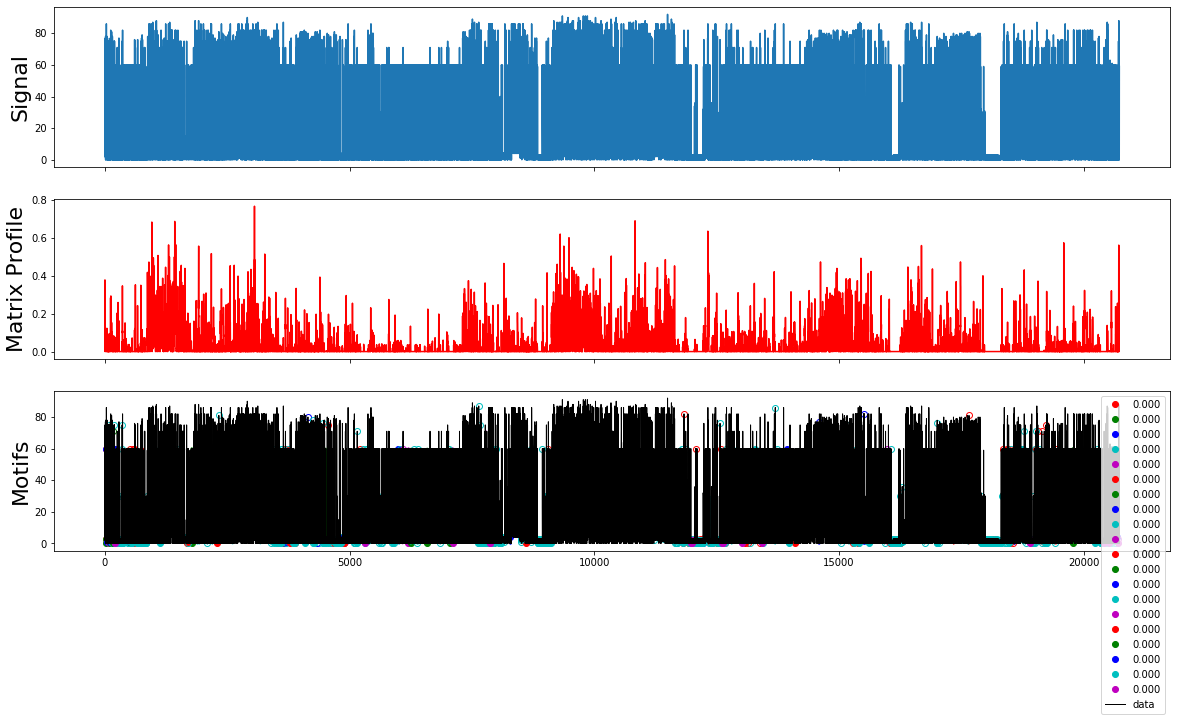

['c-chigh', 'break1', 'c-chigh', 'break1', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 'break1', 'c-

In [376]:
get_exact_patterns(sax_s4)

In [377]:
sax_o4 = get_patterns_bins1(o4, bins4)

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mistr\Anaconda3\lib\site-packages\pandas\core\generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This

Start encoding....
Done encoding.
Get labels...
Labels done.
Start SAX transformation...
SAX transformation done.


In [378]:
most_common(sax_o4)

Total Number of patterns: 101
bbbeb, number of occurances:  4241
['c-bmed', 'v1', 'c-bmed', 'l1', 'c-chigh']
['v1', 'c-chigh', 'v1', 'e1', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 's2', 'c-bmed']
['c-chigh', 'break1', 'c-chigh', 'e1', 'c-bmed']
['c-chigh', 'v1', 'c-alow', 's2', 'c-bmed']
['c-bmed', 'v1', 'c-chigh', 'l1', 'c-alow']

bbebb, number of occurances:  3069
['v1', 'c-bmed', 'l1', 'c-chigh', 'v1']
['c-bmed', 'v1', 'l1', 'c-bmed', 'v1']
['break1', 'c-chigh', 's2', 'c-bmed', 'v1']
['break1', 'c-chigh', 'e1', 'c-bmed', 'v1']
['c-bmed', 'v1', 'e1', 'c-bmed', 'v1']
['c-chigh', 'v1', 's1', 'c-bmed', 'v1']

bebbb, number of occurances:  4252
['c-bmed', 'l1', 'c-chigh', 'v1', 'c-chigh']
['v1', 'e1', 'c-bmed', 'v1', 'c-chigh']
['v1', 's1', 'c-bmed', 'v1', 'c-bmed']
['v1', 's2', 'c-alow', 'v1', 'c-bmed']
['c-alow', 's2', 'c-bmed', 'v1', 'c-bmed']
['c-chigh', 's2', 'c-bmed', 'v1', 'c-bmed']

ebbbb, number of occurances:  3170
['l1', 'c-chigh', 'v1', 'c-chigh', 'break1']
['e1', 'c-bmed',

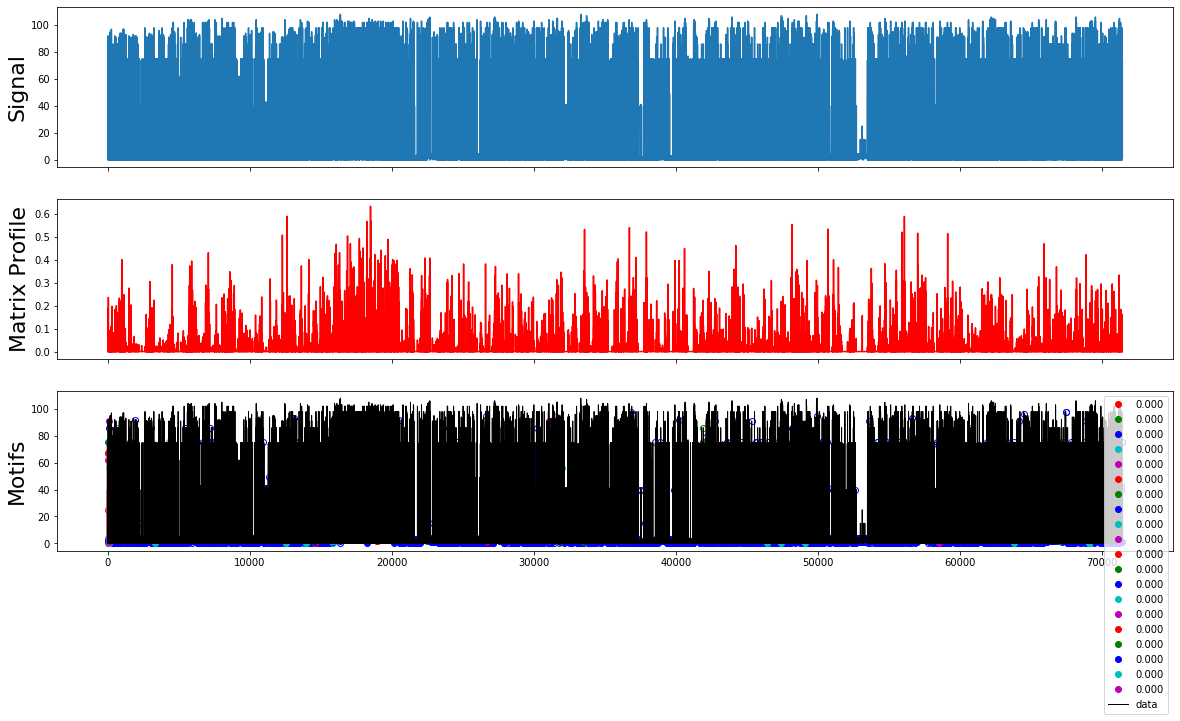

['c-bmed', 'l1', 'c-chigh', 'v1', 'c-chigh']
['c-bmed', 'l1', 'c-chigh', 'v1', 'c-chigh']

['v1', 'c-chigh', 'break1', 'c-chigh', 'e1']
['v1', 'c-chigh', 'break1', 'c-chigh', 'e1']
['v1', 'c-chigh', 'break1', 'c-chigh', 'e1']
['v1', 'c-chigh', 'break1', 'c-chigh', 'e1']

['c-bmed', 'v1', 's2', 'c-alow', 'v1']
['c-bmed', 'v1', 's2', 'c-alow', 'v1']

['c-alow', 'v1', 'c-bmed', 'break1', 'c-bmed']
['c-alow', 'v1', 'c-bmed', 'break1', 'c-bmed']
['c-alow', 'v1', 'c-bmed', 'break1', 'c-bmed']
['c-alow', 'v1', 'c-bmed', 'break1', 'c-bmed']
['c-alow', 'v1', 'c-bmed', 'break1', 'c-bmed']
['c-alow', 'v1', 'c-bmed', 'break1', 'c-bmed']
['c-alow', 'v1', 'c-bmed', 'break1', 'c-bmed']
['c-alow', 'v1', 'c-bmed', 'break1', 'c-bmed']
['c-alow', 'v1', 'c-bmed', 'break1', 'c-bmed']
['c-alow', 'v1', 'c-bmed', 'break1', 'c-bmed']
['c-alow', 'v1', 'c-bmed', 'break1', 'c-bmed']

['s2', 'e1', 'c-bmed', 'v1', 'c-alow']
['s2', 'e1', 'c-bmed', 'v1', 'c-alow']

['s3', 'c-bmed', 'break1', 'c-bmed', 'break1']
['s3'

In [379]:
get_exact_patterns(sax_o4)

In [381]:
bins_all = bins_qnt(act_c[1])
bins_all

[3.0, 10.0, 27.0]

In [382]:
sax_all = get_patterns_bins1(all1, bins_all)

C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\mistr\Anaconda3\lib\site-packages\pandas\core\generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\mistr\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This

Start encoding....
Done encoding.
Get labels...
Labels done.
Start SAX transformation...
SAX transformation done.


In [387]:
most_common(sax_all, 10000)

Total Number of patterns: 5
bbbeb, number of occurances:  13881
['c-chigh', 'break1', 'v1', 'stop1', 'c-chigh']
['v2', 'break1', 'c-chigh', 'e1', 'c-alow']
['c-bmed', 'break1', 'c-bmed', 'e1', 'c-alow']
['c-chigh', 'break1', 'c-bmed', 'e5', 'c-chigh']
['c-bmed', 'break1', 'c-bmed', 'e1', 'break1']
['c-bmed', 'v1', 'c-alow', 's3', 'c-bmed']

bebeb, number of occurances:  25533
['v1', 'stop1', 'c-chigh', 'stop1', 'c-chigh']
['c-bmed', 'l2', 'c-chigh', 's1', 'c-chigh']
['c-bmed', 'e1', 'c-bmed', 'e1', 'c-bmed']
['c-chigh', 'z1', 'break1', 'l1', 'c-alow']
['c-chigh', 's1', 'c-chigh', 'l1', 'c-chigh']
['c-bmed', 'v1', 'c-bmed', 'v1', 'c-bmed']

bebbb, number of occurances:  14495
['c-alow', 'stop1', 'c-chigh', 'break1', 'c-bmed']
['c-alow', 'l1', 'c-chigh', 'v2', 'break1']
['v1', 's2', 'c-alow', 'v1', 'c-bmed']
['v2', 'z2', 'v2', 'c-bmed', 'v1']
['v1', 'e2', 'c-alow', 'break1', 'c-bmed']
['c-alow', 's3', 'c-bmed', 'break1', 'c-bmed']

dadad, number of occurances:  21348
['l1', 'c-alow', 'l1

In [386]:
#get_exact_patterns(sax_all)